# Section 2.2.2: Exponential Time-to-Event Prediction Model Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to implement the exponential time-to-event prediction model (Examples 2.2.1 and 2.2.2 in Section 2.2.2 of the monograph) as a PyTorch model. We specifically apply this model to the SUPPORT dataset (Knaus et al., 1995), which looks at the time until death (in days) of severely ill hospitalized patients with various diseases (where we treat the "time origin"---where we measure time until death from---to be when a patient first enters the study). We compute all the evaluation metrics of Section 2.4 that we discussed in detail.

### Loading in the SUPPORT dataset

We have written code already that loads in the SUPPORT dataset (using the same 14 features and the same number of patients as the DeepSurv paper (Katzman et al., 2018)) and splits it into training, validation, and test sets. We do this splitting in two steps:

1. We first get a 70%/30% split of the data from a helper function we have written (the `load_dataset` function in `datasets.py`). The 70% part we refer to as the "full training set", whereas the 30% part is the test set.
2. We then do a random 80%/20% split the full training set into the actual training set and a validation set.

Thus, overall what we have done is taken the full dataset and split it into 56%/14%/30% training/validation/test sets.

As we shall see shortly, the main neural network training procedure (minibatch gradient descent) uses the training set. The validation set is meant to simulate the true test set that we do not look at whatsoever during training. We use the validation set for tuning hyperparameters. For the simple exponential time-to-event prediction model, there are actually no hyperparameters of the model itself, but we could still tune on optimizer settings for minibatch gradient descent, such as the number of epochs, the batch size, the learning rate, or whether to stop training early (e.g., if there is no validation set loss error improvement after 10 training epochs, then stop training and return the model parameters to whatever their values were that achieved the best validation set loss). Later in this demo, as an illustrative example, we use the validation set to tune on the number of epochs used for training.

Note that at times in the code, we add the suffix `_np` to a Python variable to indicate that it is a NumPy array, and `_df` to indicate that it is a Pandas DataFrame. For PyTorch tensors, we typically do not add a suffix. This is because often the most involved parts of our demo code are in PyTorch, and in these parts, we try to avoid having the variable names get unwieldy.

In [1]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_np, D_full_train_np, \
        X_test_raw_np, Y_test_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('support')

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_np, Y_val_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 4968
Validation set size 1243
Test set size 2662

Features before preprocessing (14 total):
['age', 'female', 'race', 'num.co', 'diabetes', 'dementia', 'ca', 'meanbp', 'hrt', 'resp', 'temp', 'wblc', 'sod', 'crea']

Features after preprocessing (19 total):
['age_std', 'female', 'num.co_norm', 'diabetes', 'dementia', 'ca_norm', 'meanbp_std', 'hrt_std', 'resp_std', 'temp_std', 'wblc_std', 'sod_std', 'crea_std', 'race_blank', 'race_asian', 'race_black', 'race_hispanic', 'race_other', 'race_white']

Events: ['death']



We fit and apply a preprocessor that we have written (see `datasets.py` for details on preprocessing) to get a "standardized" or "normalized" version of the training set.

In [2]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
print('Number of features before preprocessing:', X_train_raw_np.shape[1])
print('Number of features after preprocessing:', X_train_np.shape[1])

Number of features before preprocessing: 14
Number of features after preprocessing: 19


Much like how we wouldn't learn the preprocessor function so that it peeks at the true test set, we don't learn the preprocessor function so that it peeks at the validation set either. For this reason, notice that earlier we constructed the `preprocessor` object only using the training set and *not* also the validation set. We can apply the already learned `preprocessor` object (fitted to the training set) now to the validation set.

In [3]:
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Quick display of what the tabular data look like before and after preprocessing

Here's what the raw features look like:

In [4]:
import pandas as pd
X_train_raw_df = pd.DataFrame(X_train_raw_np, columns=features_before_preprocessing)
X_train_raw_df.head()

,age,female,race,num.co,diabetes,dementia,ca,meanbp,hrt,resp,temp,wblc,sod,crea
0,22.726990,1.0,2.0,0.0,0.0,0.0,0.0,99.0,112.0,40.0,38.500000,6.799805,134.0,0.799927
1,59.460999,1.0,5.0,1.0,0.0,0.0,2.0,52.0,175.0,26.0,38.898441,11.298828,131.0,1.000000
2,77.105957,0.0,5.0,1.0,0.0,0.0,1.0,103.0,112.0,9.0,37.593750,10.798828,143.0,0.799927
3,46.702000,0.0,5.0,1.0,0.0,0.0,0.0,71.0,71.0,24.0,36.398441,6.000000,141.0,0.799927
4,64.344971,1.0,5.0,5.0,0.0,0.0,2.0,65.0,114.0,12.0,36.500000,10.199219,138.0,1.599854


Here's what the features look like after preprocessing:

In [5]:
X_train_df = pd.DataFrame(X_train_np, columns=features_after_preprocessing)
X_train_df.head()

,age_std,female,num.co_norm,diabetes,dementia,ca_norm,meanbp_std,hrt_std,resp_std,temp_std,wblc_std,sod_std,crea_std,race_blank,race_asian,race_black,race_hispanic,race_other,race_white
0,-2.549160,1.0,0.000000,0.0,0.0,0.0,0.522356,0.455188,1.725720,1.115397,-0.602325,-0.578792,-0.574456,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.195510,1.0,0.111111,0.0,0.0,1.0,-1.185509,2.458527,0.260776,1.433982,-0.122097,-1.076014,-0.456761,0.0,0.0,0.0,0.0,0.0,1.0
2,0.935052,0.0,0.111111,0.0,0.0,0.5,0.667706,0.455188,-1.518085,0.390778,-0.175467,0.912876,-0.574456,0.0,0.0,0.0,0.0,0.0,1.0
3,-1.013014,0.0,0.111111,0.0,0.0,0.0,-0.495095,-0.848572,0.051498,-0.564965,-0.687697,0.581394,-0.574456,0.0,0.0,0.0,0.0,0.0,1.0
4,0.117420,1.0,0.555556,0.0,0.0,1.0,-0.713121,0.518786,-1.204169,-0.483761,-0.239470,0.084172,-0.103891,0.0,0.0,0.0,0.0,0.0,1.0


### Preparing training and validation sets for use with PyTorch

Note that we use a CUDA GPU if it is available.

In [6]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train_np, dtype=torch.float32, device=device)
D_train = torch.tensor(D_train_np, dtype=torch.int32, device=device)
train_data = list(zip(X_train, Y_train, D_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
Y_val = torch.tensor(Y_val_np, dtype=torch.float32, device=device)
D_val = torch.tensor(D_val_np, dtype=torch.int32, device=device)
val_data = list(zip(X_val, Y_val, D_val))

### Setting up an exponential time-to-event prediction model

In the monograph, specifically for equation (2.6), we set

$$\mathbf{h}(t|x;\theta) := e^{\beta^\top x + \psi}.$$

How we implement this in code is that we actually model the *log* of $\mathbf{h}(t|x;\theta)$:

$$\log \mathbf{h}(t|x;\theta) = \beta^\top x + \psi.$$

As this just corresponds to a linear model, we can use PyTorch's `nn.Linear`, where the number of input features corresponds to the number of dimensions in $x$, the number of output features is 1, and--by default--`nn.Linear` includes a bias term (which will correspond to the $\psi$ variable above). Note that the linear model's weights correspond to what we called $\beta$.

In [7]:
import torch.nn as nn

torch.manual_seed(0)

num_input_features = X_train.size(1)

# simple neural net model that just does an inner product + a bias
# (note that constructing an nn.Linear object also does random
# parameter initialization)
log_hazards_model = nn.Linear(num_input_features, 1).to(device)

Right now the parameters have been randomly initialized as follows:

In [8]:
log_hazards_model.weight  # this is what is called beta in the monograph in equation (2.6)

Parameter containing:
tensor([[-0.0017,  0.1231, -0.1888, -0.1688, -0.0884,  0.0615, -0.0045,  0.1819,
         -0.0204,  0.0607, -0.0693, -0.0451, -0.2192, -0.1519, -0.0946,  0.0085,
          0.0907,  0.1377, -0.1555]], device='cuda:0', requires_grad=True)

In [9]:
log_hazards_model.bias  # this is what is called psi in the monograph in equation (2.6)

Parameter containing:
tensor([-0.0999], device='cuda:0', requires_grad=True)

### Specifying the training loss function

In [10]:
def exp_nll_loss(predicted_log_hazards, Y_true, D_true):
    # the three inputs should all be 1D PyTorch tensors with the same number of entries

    # the loss is precisely L_{Hazard-NLL} given in Example 2.2.2 of the monograph
    return -(D_true * predicted_log_hazards - Y_true * (predicted_log_hazards.exp())).mean()

### Training the model using minibatch gradient descent

As an illustrative example, in this code, we use the validation set to decide on whether to use a previous epoch's learned model parameters. This could be viewed as a form of hyperparameter tuning where we are effectively selecting how many epochs to train the model for based on whichever achieves the best validation set loss.

In [11]:
from copy import deepcopy
from torch.utils.data import DataLoader

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 1e-1

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(log_hazards_model.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    log_hazards_model.train()
    for X_batch, Y_batch, D_batch in train_loader:
        log_hazards_batch = log_hazards_model(X_batch).view(-1)
        loss_batch = exp_nll_loss(log_hazards_batch, Y_batch, D_batch)
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    log_hazards_model.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            batch_num_points = X_batch.size(0)
            log_hazards_batch = log_hazards_model(X_batch).view(-1)
            train_loss += exp_nll_loss(log_hazards_batch, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            batch_num_points = X_batch.size(0)
            log_hazards_batch = log_hazards_model(X_batch).view(-1)
            val_loss += exp_nll_loss(log_hazards_batch, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(log_hazards_model.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
log_hazards_model.load_state_dict(best_params)

Epoch 1 - train loss 8.074995994567871 - val loss 8.270499229431152
Epoch 2 - train loss 6.748238563537598 - val loss 6.854441165924072
Epoch 3 - train loss 6.300990104675293 - val loss 6.365610122680664
Epoch 4 - train loss 6.040884971618652 - val loss 6.086954116821289
Epoch 5 - train loss 5.875169277191162 - val loss 5.907680988311768
Epoch 6 - train loss 5.7593255043029785 - val loss 5.784478187561035
Epoch 7 - train loss 5.673421859741211 - val loss 5.696872234344482
Epoch 8 - train loss 5.604191303253174 - val loss 5.623073577880859
Epoch 9 - train loss 5.544813632965088 - val loss 5.562973976135254
Epoch 10 - train loss 5.491061210632324 - val loss 5.5066986083984375
Epoch 11 - train loss 5.442178726196289 - val loss 5.456383228302002
Epoch 12 - train loss 5.396799564361572 - val loss 5.4111409187316895
Epoch 13 - train loss 5.354944229125977 - val loss 5.370354175567627
Epoch 14 - train loss 5.31557035446167 - val loss 5.331908226013184
Epoch 15 - train loss 5.281093120574951 -

<All keys matched successfully>

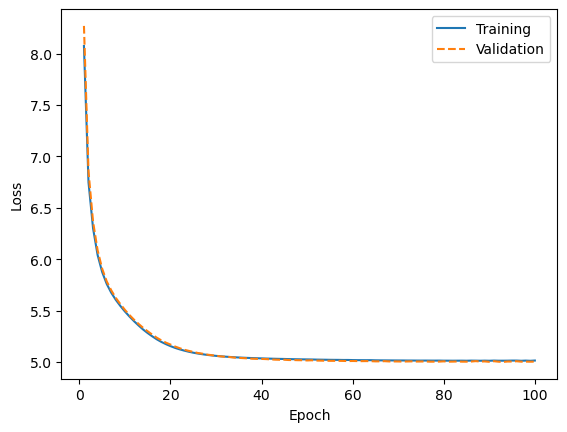

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

After training the model, the model parameters are as follows:

In [13]:
log_hazards_model.weight  # this is what is called beta in the monograph in equation (2.6)

Parameter containing:
tensor([[ 0.2851, -0.1580,  0.0786,  0.0160,  0.6156,  1.2009, -0.0991,  0.1658,
         -0.0120, -0.0124,  0.0415, -0.0505,  0.0799, -2.8905, -3.3175, -3.2151,
         -3.3408, -3.3896, -3.4003]], device='cuda:0', requires_grad=True)

In [14]:
log_hazards_model.bias  # this is what is called psi in the monograph in equation (2.6)

Parameter containing:
tensor([-3.4692], device='cuda:0', requires_grad=True)

### Predicting test set survival curves

We begin by preprocessing the test data using the preprocessor built using training data.

In [15]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor)

Next, we apply the neural net model to the test data. We convert the resulting log hazard values to NumPy arrays since the plotting and evaluation code later on does not need nor use PyTorch.

In [16]:
X_test = torch.tensor(X_test_np, dtype=torch.float, device=device)
with torch.no_grad():
    log_hazards_test = log_hazards_model(X_test)
    log_hazards_test_np = log_hazards_test.cpu().numpy()
print(log_hazards_test_np.shape)

(2662, 1)


To back out a survival curve, for simplicity we just use a time grid specified by the unique times in the test data (this is not the only way to specify a time grid; for examples of other ways, see Section 2.3.2 of the monograph).

In [17]:
import numpy as np
time_grid_test_np = np.unique(Y_test_np)
surv_test_np = np.exp(-time_grid_test_np*np.exp(log_hazards_test_np))  # equation (2.8) of the monograph applied to every test point
print(surv_test_np.shape)

(2662, 1061)


Here's a plot of the predicted survival function for the 0th test data point:

Text(0, 0.5, 'Survival probability')

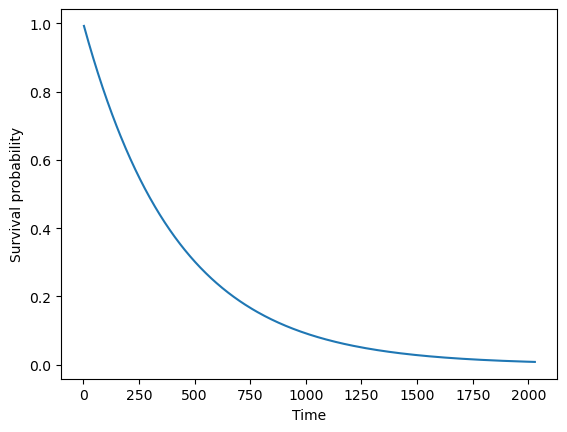

In [18]:
plt.plot(time_grid_test_np, surv_test_np[0])
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Computing test set evaluation metrics

#### Concordance index (Harrell et al., 1982) using the scikit-survival implementation (Pölsterl, 2020)

In [19]:
from sksurv.metrics import concordance_index_censored

C_index = concordance_index_censored(D_test_np.astype(bool), Y_test_np, log_hazards_test_np.flatten())[0]
print(f"Harrell's concordance index: {C_index}")

Harrell's concordance index: 0.6015103136584986


#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

We had mentioned in the monograph that time-dependent concordance index (Antolini et al., 2005) becomes the same as Harrell's concordance index when the proportional hazards assumption holds, but we had mentioned this in the context where we do not treat ties (in predicted log hazards) in a special manner (i.e., we just apply Definitions 2.4.1 and 2.4.2 of the monograph). When there are ties, the code here handles ties a bit differently which is why it is possible for Harrell's concordance index to be close to but not identical to Antolini et al.'s time-dependent concordance index.

In [20]:
from pycox.evaluation import EvalSurv

# PyCox's EvalSurv expects the predicted test data's survival functions to be in
# a Pandas DataFrame where the rows index time, and the columns index data points
surv_test_df = pd.DataFrame(surv_test_np.T, index=time_grid_test_np)
eval_pycox = EvalSurv(surv_test_df, Y_test_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')

print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.6015091745851251


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

The training data are used to estimate the inverse censoring probability weights (see Remark 2.4.1).

In [21]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(time_grid_test_np)),
                     int(.5 * len(time_grid_test_np)),
                     int(.75 * len(time_grid_test_np))]

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]
    surv_values_at_eval_time_np = surv_test_np[:, eval_time_index]
    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 316.0 - truncated time-dependent concordance: 0.5953761399115698
Eval time 693.0 - truncated time-dependent concordance: 0.6016806042300841
Eval time 1291.0 - truncated time-dependent concordance: 0.6030430535603264


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

Again, the training data are used to estimate the inverse censoring probability weights (see Remark 2.4.1).

In [22]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]
    surv_values_at_eval_time_np = surv_test_np[:, eval_time_index]
    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 316.0 - time-dependent AUC: 0.6615151728908589
Eval time 693.0 - time-dependent AUC: 0.6973356286487862
Eval time 1291.0 - time-dependent AUC: 0.7083580841311308


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

Again, the training data are used to estimate the inverse censoring probability weights (see Remark 2.4.1).

In [23]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_np, time_grid_test_np,
                         Y_test_np, D_test_np,
                         Y_train_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(time_grid_test_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 316.0 - Brier score: 0.25470911933258444


/home/george/anaconda3/lib/python3.12/site-packages/SurvivalEVAL/Evaluator.py:59: UserWarning: The first time coordinate is not 0. A authentic survival curve should start from 0 with 100% survival probability. \Adding 0 to the beginning of the time coordinates and 1 to the beginning of the predicted curves.
  warnings.warn("The first time coordinate is not 0. "


Eval time 693.0 - Brier score: 0.2068126005344934
Eval time 1291.0 - Brier score: 0.19407589412033474
Integrated Brier score: 0.19434097601763511


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

We reuse the `eval` object defined in the previous code cell. However, we point out that we actually do *not* need to provide training labels. In other words, the code cell below would still run if we started it by re-defining the `eval` object as follows:

```
eval = SurvivalEvaluator(surv_test_np, time_grid_test_np, Y_test_np, D_test_np)
```

In [24]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is not D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

The training data are used to fit a Kaplan-Meier estimator (which is used in both the margin and PO approaches for getting a pseudo ground truth survival time for censored data; also, this Kaplan-Meier estimator is also used to compute weights for different censored evaluation data points).

In [25]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 640.1538552007486


In [26]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 758.3064709270622


# Section 2.2.2: Exponential Time-to-Event Prediction Model Demo (Rotterdam/GBSG datasets)

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo is nearly identical to the exponential time-to-event prediction model demo for the SUPPORT dataset (`S2.2.2_Exponential.ipynb`). The only difference is that this notebook instead applies the model to the Rotterdam tumor bank (Foekens et al., 2000) and GBSG datasets (Schumacher et al., 1994). These datasets are of breast cancer patients who are node-positive. The outcome of interest is recurrence-free survival time (namely, the number of months starting from primary surgery until death or disease recurrence--whichever happened sooner). Specifically, we train on the Rotterdam dataset and test on the GBSG dataset, as is done in the DeepSurv paper (Katzman et al., 2018).

Importantly, the only change to the code is in loading in the data. The rest of the code in the notebook is actually the same as for the SUPPORT dataset!

### Loading in the Rotterdam/GBSG datasets

We have written code already that loads in the Rotterdam/GBSG datasets. Note that unlike in the SUPPORT dataset, where the full training set and the test set are obtained via a random split, here we treat the Rotterdam dataset as the full training set and the GBSG dataset as the test set. In more detail, our data loading code does the following:

- Randomly split the Rotterdam tumor bank dataset into 80%/20% train/validation sets.
- Treat the GBSG data as the test set.

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_np, D_full_train_np, \
        X_test_raw_np, Y_test_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('rotterdam-gbsg')

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_np, Y_val_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 1236
Validation set size 310
Test set size 686

Features before preprocessing (7 total):
['horTh', 'tsize', 'menostat', 'age', 'pnodes', 'progrec', 'estrec']

Features after preprocessing (7 total):
['horTh', 'tsize_norm', 'menostat', 'age_std', 'pnodes_std', 'progrec_std', 'estrec_std']

Events: ['death']



We fit and apply a preprocessor that we have written (see `datasets.py` for details on preprocessing) to get a "standardized" or "normalized" version of the training set.

In [ ]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
print('Number of features before preprocessing:', X_train_raw_np.shape[1])
print('Number of features after preprocessing:', X_train_np.shape[1])

Number of features before preprocessing: 7
Number of features after preprocessing: 7


Much like how we wouldn't learn the preprocessor function so that it peeks at the true test set, we don't learn the preprocessor function so that it peeks at the validation set either. For this reason, notice that earlier we constructed the `preprocessor` object only using the training set and *not* also the validation set. We can apply the already learned `preprocessor` object (fitted to the training set) now to the validation set.

In [ ]:
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Quick display of what the tabular data look like before and after preprocessing

Here's what the raw features look like:

In [ ]:
import pandas as pd
X_train_raw_df = pd.DataFrame(X_train_raw_np, columns=features_before_preprocessing)
X_train_raw_df.head()

,horTh,tsize,menostat,age,pnodes,progrec,estrec
0,0.0,0.0,0.0,48.0,1.0,805.0,198.0
1,0.0,1.0,1.0,74.0,1.0,166.0,382.0
2,1.0,0.0,1.0,67.0,6.0,92.0,339.0
3,0.0,1.0,0.0,48.0,1.0,635.0,411.0
4,0.0,1.0,0.0,57.0,2.0,23.0,0.0


Here's what the features look like after preprocessing:

In [ ]:
X_train_df = pd.DataFrame(X_train_np, columns=features_after_preprocessing)
X_train_df.head()

,horTh,tsize_norm,menostat,age_std,pnodes_std,progrec_std,estrec_std
0,0.0,0.0,0.0,-0.631631,-0.855306,2.190318,0.152950
1,0.0,0.5,1.0,1.379873,-0.855306,0.046580,0.898470
2,1.0,0.0,1.0,0.838314,0.173659,-0.201678,0.724245
3,0.0,0.5,0.0,-0.631631,-0.855306,1.619996,1.015970
4,0.0,0.5,0.0,0.064659,-0.649513,-0.433162,-0.649294


### Preparing training and validation sets for use with PyTorch

Note that we use a CUDA GPU if it is available.

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train_np, dtype=torch.float32, device=device)
D_train = torch.tensor(D_train_np, dtype=torch.int32, device=device)
train_data = list(zip(X_train, Y_train, D_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
Y_val = torch.tensor(Y_val_np, dtype=torch.float32, device=device)
D_val = torch.tensor(D_val_np, dtype=torch.int32, device=device)
val_data = list(zip(X_val, Y_val, D_val))

### Setting up an exponential time-to-event prediction model

In the monograph, specifically for equation (2.6), we set

$$\mathbf{h}(t|x;\theta) := e^{\beta^\top x + \psi}.$$

How we implement this in code is that we actually model the *log* of $\mathbf{h}(t|x;\theta)$:

$$\log \mathbf{h}(t|x;\theta) = \beta^\top x + \psi.$$

As this just corresponds to a linear model, we can use PyTorch's `nn.Linear`, where the number of input features corresponds to the number of dimensions in $x$, the number of output features is 1, and--by default--`nn.Linear` includes a bias term (which will correspond to the $\psi$ variable above). Note that the linear model's weights correspond to what we called $\beta$.

In [ ]:
import torch.nn as nn

torch.manual_seed(0)

num_input_features = X_train.size(1)

# simple neural net model that just does an inner product + a bias
# (note that constructing an nn.Linear object also does random
# parameter initialization)
log_hazards_model = nn.Linear(num_input_features, 1).to(device)

Right now the parameters have been randomly initialized as follows:

In [ ]:
log_hazards_model.weight  # this is what is called beta in the monograph in equation (2.6)

Parameter containing:
tensor([[-0.0028,  0.2028, -0.3111, -0.2782, -0.1456,  0.1014, -0.0075]],
       device='cuda:0', requires_grad=True)

In [ ]:
log_hazards_model.bias  # this is what is called psi in the monograph in equation (2.6)

Parameter containing:
tensor([0.2997], device='cuda:0', requires_grad=True)

### Specifying the training loss function

In [ ]:
def exp_nll_loss(predicted_log_hazards, Y_true, D_true):
    # the three inputs should all be 1D PyTorch tensors with the same number of entries

    # the loss is precisely L_{Hazard-NLL} given in Example 2.2.2 of the monograph
    return -(D_true * predicted_log_hazards - Y_true * (predicted_log_hazards.exp())).mean()

### Training the model using minibatch gradient descent

As an illustrative example, in this code, we use the validation set to decide on whether to use a previous epoch's learned model parameters. This could be viewed as a form of hyperparameter tuning where we are effectively selecting how many epochs to train the model for based on whichever achieves the best validation set loss.

In [ ]:
from copy import deepcopy
from torch.utils.data import DataLoader

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 1e-1

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(log_hazards_model.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    log_hazards_model.train()
    for X_batch, Y_batch, D_batch in train_loader:
        log_hazards_batch = log_hazards_model(X_batch).view(-1)
        loss_batch = exp_nll_loss(log_hazards_batch, Y_batch, D_batch)
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    log_hazards_model.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            batch_num_points = X_batch.size(0)
            log_hazards_batch = log_hazards_model(X_batch).view(-1)
            train_loss += exp_nll_loss(log_hazards_batch, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            batch_num_points = X_batch.size(0)
            log_hazards_batch = log_hazards_model(X_batch).view(-1)
            val_loss += exp_nll_loss(log_hazards_batch, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(log_hazards_model.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
log_hazards_model.load_state_dict(best_params)

Epoch 1 - train loss 11.039381980895996 - val loss 10.920942306518555
Epoch 2 - train loss 5.348545074462891 - val loss 5.13672399520874
Epoch 3 - train loss 4.35257625579834 - val loss 4.1131510734558105
Epoch 4 - train loss 4.071681976318359 - val loss 3.814147472381592
Epoch 5 - train loss 3.9604241847991943 - val loss 3.6909306049346924
Epoch 6 - train loss 3.9057838916778564 - val loss 3.630040168762207
Epoch 7 - train loss 3.871673345565796 - val loss 3.5917775630950928
Epoch 8 - train loss 3.8466556072235107 - val loss 3.564443588256836
Epoch 9 - train loss 3.8259243965148926 - val loss 3.5412628650665283
Epoch 10 - train loss 3.808465003967285 - val loss 3.5221967697143555
Epoch 11 - train loss 3.7929275035858154 - val loss 3.504974126815796
Epoch 12 - train loss 3.7787766456604004 - val loss 3.4900894165039062
Epoch 13 - train loss 3.7653963565826416 - val loss 3.4756863117218018
Epoch 14 - train loss 3.7532386779785156 - val loss 3.461940288543701
Epoch 15 - train loss 3.7422

<All keys matched successfully>

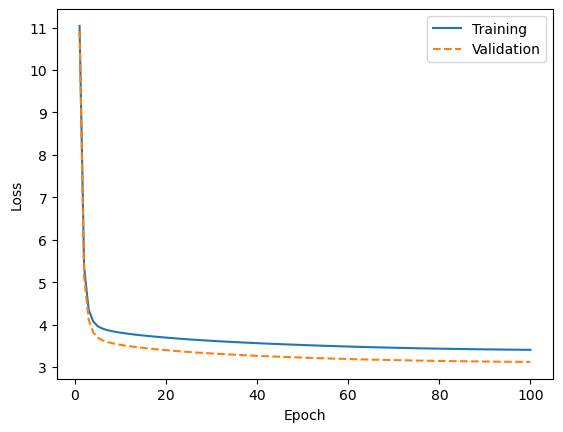

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

After training the model, the model parameters are as follows:

In [ ]:
log_hazards_model.weight  # this is what is called beta in the monograph in equation (2.6)

Parameter containing:
tensor([[-0.0490, -0.1835, -0.6231,  0.3290,  0.1977, -0.0458, -0.0363]],
       device='cuda:0', requires_grad=True)

In [ ]:
log_hazards_model.bias  # this is what is called psi in the monograph in equation (2.6)

Parameter containing:
tensor([-3.8052], device='cuda:0', requires_grad=True)

### Predicting test set survival curves

We begin by preprocessing the test data using the preprocessor built using training data.

In [ ]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor)

Next, we apply the neural net model to the test data. We convert the resulting log hazard values to NumPy arrays since the plotting and evaluation code later on does not need nor use PyTorch.

In [ ]:
X_test = torch.tensor(X_test_np, dtype=torch.float, device=device)
with torch.no_grad():
    log_hazards_test = log_hazards_model(X_test)
    log_hazards_test_np = log_hazards_test.cpu().numpy()
print(log_hazards_test_np.shape)

(686, 1)


To back out a survival curve, for simplicity we just use a time grid specified by the unique times in the test data (this is not the only way to specify a time grid; for examples of other ways, see Section 2.3.2 of the monograph).

In [ ]:
import numpy as np
time_grid_test_np = np.unique(Y_test_np)
surv_test_np = np.exp(-time_grid_test_np*np.exp(log_hazards_test_np))  # equation (2.8) of the monograph applied to every test point
print(surv_test_np.shape)

(686, 574)


Here's a plot of the predicted survival function for the 0th test data point:

Text(0, 0.5, 'Survival probability')

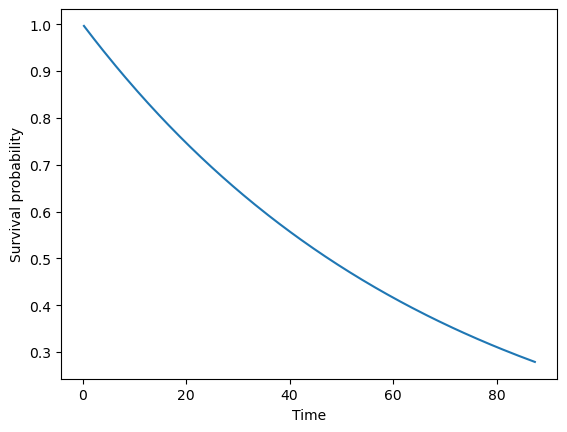

In [ ]:
plt.plot(time_grid_test_np, surv_test_np[0])
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Computing test set evaluation metrics

#### Concordance index (Harrell et al., 1982) using the scikit-survival implementation (Pölsterl, 2020)

In [ ]:
from sksurv.metrics import concordance_index_censored

C_index = concordance_index_censored(D_test_np.astype(bool), Y_test_np, log_hazards_test_np.flatten())[0]
print(f"Harrell's concordance index: {C_index}")

Harrell's concordance index: 0.5766201755440664


#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

We had mentioned in the monograph that time-dependent concordance index (Antolini et al., 2005) becomes the same as Harrell's concordance index when the proportional hazards assumption holds, but we had mentioned this in the context where we do not treat ties (in predicted log hazards) in a special manner (i.e., we just apply Definitions 2.4.1 and 2.4.2 of the monograph). When there are ties, the code here handles ties a bit differently which is why it is possible for Harrell's concordance index to be close to but not identical to Antolini et al.'s time-dependent concordance index.

In [ ]:
from pycox.evaluation import EvalSurv

# PyCox's EvalSurv expects the predicted test data's survival functions to be in
# a Pandas DataFrame where the rows index time, and the columns index data points
surv_test_df = pd.DataFrame(surv_test_np.T, index=time_grid_test_np)
eval_pycox = EvalSurv(surv_test_df, Y_test_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')

print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.5766126608151978


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

The training data are used to estimate the inverse censoring probability weights (see Remark 2.4.1).

In [ ]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(time_grid_test_np)),
                     int(.5 * len(time_grid_test_np)),
                     int(.75 * len(time_grid_test_np))]

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]
    surv_values_at_eval_time_np = surv_test_np[:, eval_time_index]
    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 18.365503311157227 - truncated time-dependent concordance: 0.5907428144924503
Eval time 34.891170501708984 - truncated time-dependent concordance: 0.5913295927370565
Eval time 55.195072174072266 - truncated time-dependent concordance: 0.5703883230825377


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

Again, the training data are used to estimate the inverse censoring probability weights (see Remark 2.4.1).

In [ ]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]
    surv_values_at_eval_time_np = surv_test_np[:, eval_time_index]
    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 18.365503311157227 - time-dependent AUC: 0.5940699751073386
Eval time 34.891170501708984 - time-dependent AUC: 0.6100096678341871
Eval time 55.195072174072266 - time-dependent AUC: 0.5520558565050695


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

Again, the training data are used to estimate the inverse censoring probability weights (see Remark 2.4.1).

In [ ]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_np, time_grid_test_np,
                         Y_test_np, D_test_np,
                         Y_train_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(time_grid_test_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 18.365503311157227 - Brier score: 0.15754649136867882
Eval time 34.891170501708984 - Brier score: 0.21402761630320982
Eval time 55.195072174072266 - Brier score: 0.19387449415779673
Integrated Brier score: 0.1391653176492881


/home/george/anaconda3/lib/python3.12/site-packages/SurvivalEVAL/Evaluator.py:59: UserWarning: The first time coordinate is not 0. A authentic survival curve should start from 0 with 100% survival probability. \Adding 0 to the beginning of the time coordinates and 1 to the beginning of the predicted curves.
  warnings.warn("The first time coordinate is not 0. "


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

We reuse the `eval` object defined in the previous code cell. However, we point out that we actually do *not* need to provide training labels. In other words, the code cell below would still run if we started it by re-defining the `eval` object as follows:

```
eval = SurvivalEvaluator(surv_test_np, time_grid_test_np, Y_test_np, D_test_np)
```

In [ ]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is not D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

The training data are used to fit a Kaplan-Meier estimator (which is used in both the margin and PO approaches for getting a pseudo ground truth survival time for censored data; also, this Kaplan-Meier estimator is also used to compute weights for different censored evaluation data points).

In [ ]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 27.93611640257301


In [ ]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 31.52283437264418


# Section 2.2.2: Weibull Time-to-Event Prediction Model Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to implement the Weibull time-to-event prediction model (Example 2.2.3 in Section 2.2.2 of the monograph) as a PyTorch model. This demo largely builds off the exponential time-to-event prediction model demo (`S2.2.2_Exponential.ipynb`), so please look at that first as it describes the different steps of the experimental setup in more detail. In this follow-up Weibull time-to-event prediction model demo, we mainly only explain steps that are different from the earlier exponential time-to-event prediction model demo.

### Loading in the SUPPORT dataset (Knaus et al., 1995)

As with the earlier demo, we begin by defining the training, validation, and test sets.

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_np, D_full_train_np, \
        X_test_raw_np, Y_test_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('support')

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_np, Y_val_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 4968
Validation set size 1243
Test set size 2662

Features before preprocessing (14 total):
['age', 'female', 'race', 'num.co', 'diabetes', 'dementia', 'ca', 'meanbp', 'hrt', 'resp', 'temp', 'wblc', 'sod', 'crea']

Features after preprocessing (19 total):
['age_std', 'female', 'num.co_norm', 'diabetes', 'dementia', 'ca_norm', 'meanbp_std', 'hrt_std', 'resp_std', 'temp_std', 'wblc_std', 'sod_std', 'crea_std', 'race_blank', 'race_asian', 'race_black', 'race_hispanic', 'race_other', 'race_white']

Events: ['death']



We fit and apply a preprocessor to the training set. We apply (but do not re-fit) the preprocessor to the validation set.

In [ ]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Preparing training and validation sets for use with PyTorch

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train_np, dtype=torch.float32, device=device)
D_train = torch.tensor(D_train_np, dtype=torch.int32, device=device)
train_data = list(zip(X_train, Y_train, D_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
Y_val = torch.tensor(Y_val_np, dtype=torch.float32, device=device)
D_val = torch.tensor(D_val_np, dtype=torch.int32, device=device)
val_data = list(zip(X_val, Y_val, D_val))

### Setting up a Weibull time-to-event prediction model

In the monograph, right after equation (2.14), we state that the Weibull model corresponds to having shape parameter $e^\phi$ and scale parameter $\exp(-\beta^\top x - \psi e^{-\phi})$. In other words:

- The log shape is given by $\phi$.
- The log scale is given by $-\beta^\top x - \psi e^{-\phi}$.

We shall implement the Weibull model using `nn.Module`, where the `forward` function outputs a 2D table (rows correspond to different data points, and there are two columns where column 0 stores log scale, and column 1 stores log shape). The reason that we specify the `forward` function in this manner is that we will use the built-in `torchsurv` Weibull loss function, which expects the output of the neural network (i.e., the output of the `forward` function) to be of the format we just stated.

In [ ]:
import torch.nn as nn

torch.manual_seed(0)

class WeibullTimeToEventModel(nn.Module):
    def __init__(self, num_input_features):
        super(WeibullTimeToEventModel, self).__init__()

        # randomly initialize parameters phi and psi to be close to 0
        self.phi = nn.Parameter(.01*torch.randn(1, dtype=torch.float))
        self.psi = nn.Parameter(.01*torch.randn(1, dtype=torch.float))

        # to randomly initialize the inner product weights (called beta in the
        # monograph), we just construct a nn.Linear object as to output a single
        # real number and we do not use a bias
        self.linear = nn.Linear(num_input_features, 1, bias=False)

    def forward(self, inputs):
        # we output log scale and log shape values since these are what torchsurv's
        # Weibull negative log likelihood loss function expects as the output of the
        # base neural network

        batch_size = inputs.size(0)

        # column 0 stores log scale, column 1 stores log shape
        log_params = torch.zeros(batch_size, 2, dtype=torch.float, device=inputs.device)

        log_params[:, 1] = self.phi  # set all log shape values to be the same
        log_params[:, 0] = (-self.linear(inputs) - self.psi*((-self.phi).exp())).view(-1)
        return log_params

num_input_features = X_train.size(1)
weibull_model = WeibullTimeToEventModel(num_input_features).to(device)

Right now the parameters have been randomly initialized as follows:

In [ ]:
weibull_model.linear.weight  # this is what is called beta in the monograph in equation (2.12)

Parameter containing:
tensor([[-0.0884,  0.0615, -0.0045,  0.1819, -0.0204,  0.0607, -0.0693, -0.0451,
         -0.2192, -0.1519, -0.0946,  0.0085,  0.0907,  0.1377, -0.1555, -0.0999,
          0.0833,  0.1905, -0.0472]], device='cuda:0', requires_grad=True)

In [ ]:
weibull_model.phi  # this is what is called phi in the monograph in equation (2.12)

Parameter containing:
tensor([0.0154], device='cuda:0', requires_grad=True)

In [ ]:
weibull_model.psi  # this is what is called psi in the monograph in equation (2.12)

Parameter containing:
tensor([-0.0029], device='cuda:0', requires_grad=True)

### Training the model using minibatch gradient descent

Just as in the exponential time-to-event prediction model demo, we use the validation set to decide on whether to use a previous epoch's learned model parameters.

In [ ]:
from copy import deepcopy
from torch.utils.data import DataLoader
from torchsurv.loss.weibull import neg_log_likelihood

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 1e-1

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(weibull_model.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    weibull_model.train()
    for X_batch, Y_batch, D_batch in train_loader:
        log_hazards_batch = weibull_model(X_batch)
        loss_batch = neg_log_likelihood(log_hazards_batch, D_batch, Y_batch)
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    weibull_model.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            log_hazards_batch = weibull_model(X_batch)

            # some loss functions have a reduction argument that can be set to 'sum'
            # to sum instead of taking a mean
            train_loss += neg_log_likelihood(log_hazards_batch, D_batch, Y_batch,
                                             reduction='sum')

            num_points += X_batch.size(0)
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            log_hazards_batch = weibull_model(X_batch)
            val_loss += neg_log_likelihood(log_hazards_batch, D_batch, Y_batch,
                                           reduction='sum')
            num_points += X_batch.size(0)
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(weibull_model.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
weibull_model.load_state_dict(best_params)

Epoch 1 - train loss 5.28985595703125 - val loss 5.249753475189209
Epoch 2 - train loss 5.090078353881836 - val loss 5.026221752166748
Epoch 3 - train loss 5.007582664489746 - val loss 4.933909893035889
Epoch 4 - train loss 4.948873043060303 - val loss 4.869334697723389
Epoch 5 - train loss 4.906196594238281 - val loss 4.823058605194092
Epoch 6 - train loss 4.875294208526611 - val loss 4.789720058441162
Epoch 7 - train loss 4.853026390075684 - val loss 4.76551628112793
Epoch 8 - train loss 4.837011337280273 - val loss 4.748401165008545
Epoch 9 - train loss 4.825368881225586 - val loss 4.735917568206787
Epoch 10 - train loss 4.816295146942139 - val loss 4.726292610168457
Epoch 11 - train loss 4.8099493980407715 - val loss 4.7195634841918945
Epoch 12 - train loss 4.804684638977051 - val loss 4.713958263397217
Epoch 13 - train loss 4.800281524658203 - val loss 4.709559440612793
Epoch 14 - train loss 4.796895980834961 - val loss 4.706185817718506
Epoch 15 - train loss 4.793860912322998 - v

<All keys matched successfully>

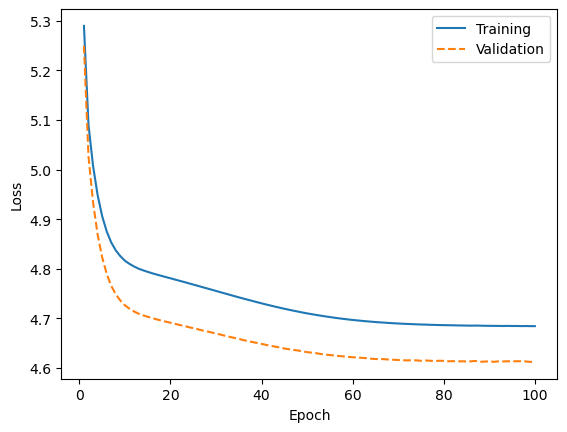

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

After training the model, the model parameters are as follows:

In [ ]:
weibull_model.linear.weight  # this is what is called beta in the monograph in equation (2.12)

Parameter containing:
tensor([[ 0.4742, -0.2208, -0.5639,  0.0936,  0.9127,  1.7130, -0.1796,  0.2298,
          0.0212, -0.0430,  0.0728, -0.0385,  0.1541, -0.7690, -1.4771, -1.3496,
         -1.5624, -1.3379, -1.6424]], device='cuda:0', requires_grad=True)

In [ ]:
weibull_model.phi  # this is what is called phi in the monograph in equation (2.12)

Parameter containing:
tensor([-0.7233], device='cuda:0', requires_grad=True)

In [ ]:
weibull_model.psi  # this is what is called psi in the monograph in equation (2.12)

Parameter containing:
tensor([-2.5321], device='cuda:0', requires_grad=True)

### Predicting test set survival curves

We begin by preprocessing the test data using the preprocessor built using training data.

In [ ]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor)

Next, we apply the neural net model to the test data. We convert the resulting log parameter values to NumPy arrays since the plotting and evaluation code later on does not need nor use PyTorch.

In [ ]:
X_test = torch.tensor(X_test_np, dtype=torch.float, device=device)
with torch.no_grad():
    log_params_test = weibull_model(X_test)
    log_params_test_np = log_params_test.cpu().numpy()

To back out a survival curve, for simplicity we just use a time grid specified by the unique times in the test data (this is not the only way to specify a time grid; for examples of other ways, see Section 2.3.2 of the monograph).

In [ ]:
import numpy as np
time_grid_test_np = np.unique(Y_test_np)

# we now use equation (2.14) of the monograph applied to every test point
# (note that np.newaxis is used to replicate the time grid across data points
# and separately to replicate estimates parameters across time)
log_scales_test_np = log_params_test_np[:, 0]
log_shapes_test_np = log_params_test_np[:, 1]
surv_test_np = np.exp(-(time_grid_test_np[np.newaxis, :]
                        / log_scales_test_np[:, np.newaxis])**(np.exp(log_shapes_test_np)[:, np.newaxis]))

Here's a plot of the predicted survival function for the 0th test data point:

Text(0, 0.5, 'Survival probability')

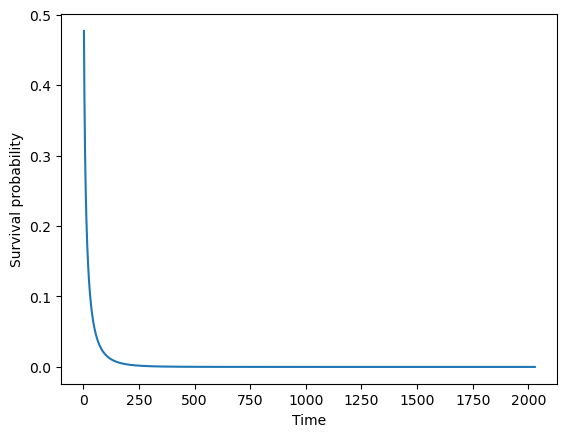

In [ ]:
plt.plot(time_grid_test_np, surv_test_np[0])
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Computing test set evaluation metrics

#### Concordance index (Harrell et al., 1982) using the scikit-survival implementation (Pölsterl, 2020)

Notice from equation (2.12) of the monograph that the Weibull time-to-event prediction model is a proportional hazards model, where the log partial hazard is precisely the negative log of the scale parameter. Thus, for Harrell's concordance index, we can treat the predicted negative log scales of the test data as the risk score estimates to rank the test data by.

In [ ]:
from sksurv.metrics import concordance_index_censored

C_index = concordance_index_censored(D_test_np.astype(bool), Y_test_np, -log_scales_test_np.flatten())[0]
print(f"Harrell's concordance index: {C_index}")

Harrell's concordance index: 0.6030088460438192


#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [ ]:
import pandas as pd
from pycox.evaluation import EvalSurv

# PyCox's EvalSurv expects the predicted test data's survival functions to be in
# a Pandas DataFrame where the rows index time, and the columns index data points
surv_test_df = pd.DataFrame(surv_test_np.T, index=time_grid_test_np)
eval_pycox = EvalSurv(surv_test_df, Y_test_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')

print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.6030088460438192


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

In [ ]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(time_grid_test_np)),
                     int(.5 * len(time_grid_test_np)),
                     int(.75 * len(time_grid_test_np))]

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]
    surv_values_at_eval_time_np = surv_test_np[:, eval_time_index]
    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 316.0 - truncated time-dependent concordance: 0.5980416221583508
Eval time 693.0 - truncated time-dependent concordance: 0.603517430263355
Eval time 1291.0 - truncated time-dependent concordance: 0.6038200719271364


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

In [ ]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]
    surv_values_at_eval_time_np = surv_test_np[:, eval_time_index]
    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 316.0 - time-dependent AUC: 0.6604852344197985
Eval time 693.0 - time-dependent AUC: 0.6929115660412561
Eval time 1291.0 - time-dependent AUC: 0.69878806226306


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_np, time_grid_test_np,
                         Y_test_np, D_test_np,
                         Y_train_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(time_grid_test_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 316.0 - Brier score: 0.45454610237192405


/home/george/anaconda3/lib/python3.12/site-packages/SurvivalEVAL/Evaluator.py:59: UserWarning: The first time coordinate is not 0. A authentic survival curve should start from 0 with 100% survival probability. \Adding 0 to the beginning of the time coordinates and 1 to the beginning of the predicted curves.
  warnings.warn("The first time coordinate is not 0. "


Eval time 693.0 - Brier score: 0.36637116974695916
Eval time 1291.0 - Brier score: 0.29045614884455423
Integrated Brier score: 0.3053999453582976


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is not D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 649.8857943087481


In [ ]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 768.3698620042896


# Section 2.3.3: Kaplan-Meier and Nelson-Aalen Estimators

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to use the Kaplan-Meier estimator (Kaplan and Meier, 1958) and the Nelson-Aalen estimator (Nelson, 1969; Aalen, 1978) from the `lifelines` package, with an optional time discretization step that is done using PyCox code. For an overview of these two estimators, please see Example 2.3.3 in Section 2.3.3 of the monograph. This demo largely builds off the exponential time-to-event prediction model demo (`S2.2.2_Exponential.ipynb`), so please look at that first as it describes the different steps of the experimental setup in more detail.

In the monograph, we derived Kaplan-Meier and Nelson-Aalen estimators as maximum likelihood estimators and, in fact, they can trivially be computed in closed form. For this reason, this demo is not going to use any PyTorch functionality. Note that this demo mostly focuses on the Kaplan-Meier estimator, which estimates a population-level survival function from training data. We briefly also show how to fit a Nelson-Aalen estimator of the population-level cumulative hazard function.

Note that the Kaplan-Meier and Nelson-Aalen estimators are population-level estimators that don't need input feature vectors and also don't have hyperparameters to tune. Thus, we will *not* split the data into training/validation/test sets. Instead, we just use a train/test split (the same first split that happens in the exponential time-to-event prediction model demo). In other words, what we called the "full training data" is the same as the "training data" for this specific demo.

**Very important:** We can treat the Kaplan-Meier estimator's survival function (fitted to the full training data) as what we would predict as the survival function for every single test point. Using this idea, we can compute nearly all of the evaluation metrics (on *test* data) that we presented in Section 2.4 of the monograph. This idea is useful because for some evaluation metrics (such as the integrated Brier score), it might not be obvious what a "baseline" score should be. The Kaplan-Meier estimator can thus be used to obtain a trivial baseline score.

### Loading in the SUPPORT dataset (Knaus et al., 1995)

The data loading is much simpler now.

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# the suffix "_np" indicates a numpy array
# (we convert arrays/tables between NumPy array, Pandas DataFrame, and PyTorch tensor formats)
_, Y_train_np, D_train_np, _, Y_test_np, D_test_np, _, _, _, _, _, _ = load_dataset('support')

print(f'Training set size {Y_train_np.shape[0]}')
print(f'Test set size {Y_test_np.shape[0]}')

Training set size 6211
Test set size 2662


### Discretizing time

Here, we just point out that if for whatever reason, the modeler would like to discretize time prior to fitting the Kaplan-Meier estimator, then this is indeed possible. By default, in the code cell below, we actually set the time steps to be the unique times of death in the dataset (but this can easily be changed by modifying the `num_time_steps` variable).

If time discretization is used (when `num_time_steps` is set to be larger than 0), then we use PyCox's provided `LabTransDiscreteTime` class that helps discretize time. Note that there are many ways to discretize time (see Section 2.3.2 of the monograph).

In [ ]:
import numpy as np

num_time_steps = 0  # set this to 0 to use all unique times of death

if num_time_steps == 0:
    Y_train_binned_np = Y_train_np
    D_train_discrete_np = D_train_np

    mask = (D_train_np == 1)  # boolean mask specifying which training points experienced death
    time_grid_train_np = np.unique(Y_train_np[mask])
else:
    # use a quantile based discretization, which could possibly end up using fewer than the
    # number of time steps requested (if it turns out that in the dataset, there are many
    # duplicate observed time values)
    from pycox.preprocessing.label_transforms import LabTransDiscreteTime
    label_transform = LabTransDiscreteTime(num_time_steps, scheme='quantiles')

    Y_train_discrete_np, D_train_discrete_np = label_transform.fit_transform(Y_train_np, D_train_np)
    # note: PyCox's discretization code allows for the possibility that the event indicator changes
    # (if a patient's survival time is known so that the event indicator is 1, but the survival time
    # is after the maximum discrete time grid time, then the patient's event indicator is changed to
    # being censored)

    time_grid_train_np = label_transform.cuts

    # note that `Y_train_discrete_np` gives the new discretized times in terms of *integer indices*
    # and not actual times; we convert these integer indices into actual discretized times:
    Y_train_binned_np = np.array([time_grid_train_np[index] for index in Y_train_discrete_np])

output_num_time_steps = len(time_grid_train_np)
print(f'Number of time steps to be used with the Kaplan-Meier estimator: {output_num_time_steps}')
print('Time grid:', time_grid_train_np)

Number of time steps to be used with the Kaplan-Meier estimator: 883
Time grid: [   3.    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.   14.
   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.   25.   26.
   27.   28.   29.   30.   31.   32.   33.   34.   35.   36.   37.   38.
   39.   40.   41.   42.   43.   44.   45.   46.   47.   48.   49.   50.
   51.   52.   53.   54.   55.   56.   57.   58.   59.   60.   61.   62.
   63.   64.   65.   66.   67.   68.   69.   70.   71.   72.   73.   74.
   75.   76.   77.   78.   79.   80.   81.   82.   83.   84.   85.   86.
   87.   88.   89.   90.   91.   92.   93.   94.   95.   96.   97.   98.
   99.  100.  101.  102.  103.  104.  105.  106.  107.  108.  109.  110.
  111.  112.  113.  114.  115.  116.  117.  118.  119.  120.  121.  122.
  123.  124.  125.  126.  127.  128.  129.  130.  132.  133.  134.  135.
  136.  137.  138.  139.  140.  141.  142.  143.  144.  145.  146.  147.
  148.  149.  150.  151.  152.  153.  154.  

### Fitting the Kaplan-Meier estimator

<Axes: xlabel='timeline'>

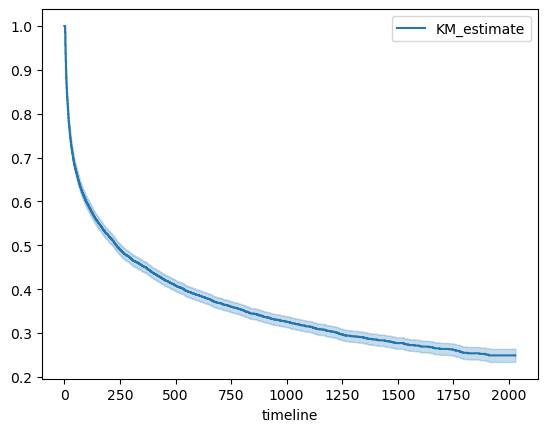

In [ ]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
kmf.fit(Y_train_binned_np, D_train_discrete_np)
kmf.plot()

In [ ]:
kmf.survival_function_

,KM_estimate
timeline,
0.0,1.000000
3.0,0.985832
4.0,0.956851
5.0,0.936242
6.0,0.919176
...,...
2024.0,0.248896
2026.0,0.248896
2027.0,0.248896


Note that by default, time 0 gets added even if it did not show up as one of the training set's observed times of death.

We store the time grid and survival function in separate NumPy tables as we will use these later.

In [ ]:
time_grid_KM_np = kmf.survival_function_.index.to_numpy()
surv_KM_np = kmf.survival_function_.to_numpy().flatten()

We could also essentially manually plot the Kaplan-Meier curve ourselves (although this doesn't plot pointwise confidence intervals).

Text(0, 0.5, 'Survival probability')

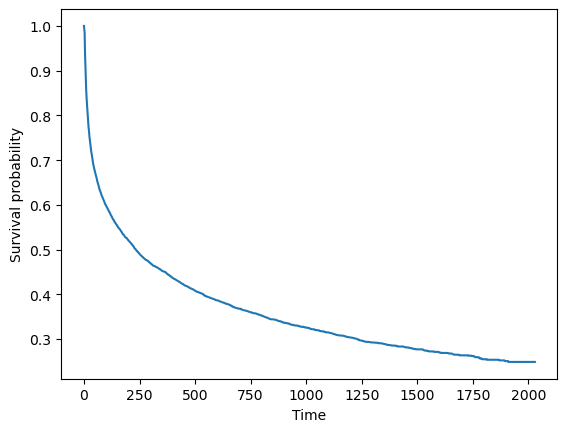

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(time_grid_KM_np, surv_KM_np)
plt.xlabel('Time')
plt.ylabel('Survival probability')

In [ ]:
from lifelines import NelsonAalenFitter

naf = NelsonAalenFitter()
naf.fit(Y_train_binned_np, D_train_discrete_np)

time_grid_NA_np = naf.cumulative_hazard_.index.to_numpy()
cumulative_hazard_NA_np = naf.cumulative_hazard_.to_numpy().flatten()

Text(0, 0.5, 'Cumulative hazard')

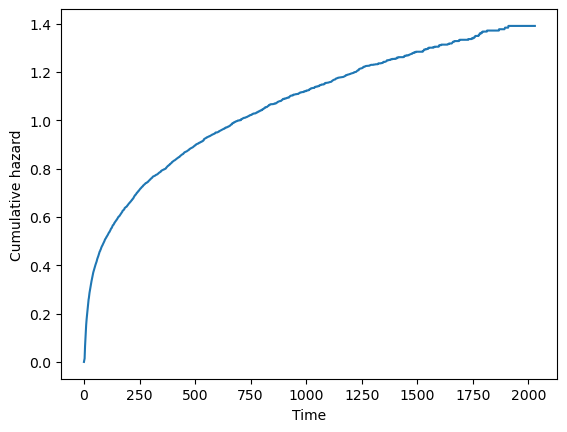

In [ ]:
plt.plot(time_grid_NA_np, cumulative_hazard_NA_np)
plt.xlabel('Time')
plt.ylabel('Cumulative hazard')

### Predicting test set survival curves

We treat the Kaplan-Meier estimator's survival function (fitted to the training data) as what we would predict to be every single test point's survival function.

In [ ]:
surv_test_np = np.tile(surv_KM_np, (Y_test_np.shape[0], 1))

### Computing test set evaluation metrics

For choosing evaluation times, we use the test set's observed times.

In [ ]:
time_grid_test_np = np.unique(Y_test_np)

#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [ ]:
import pandas as pd
from pycox.evaluation import EvalSurv

# PyCox's EvalSurv expects the predicted test data's survival functions to be in
# a Pandas DataFrame where the rows index time, and the columns index data points
surv_test_df = pd.DataFrame(surv_test_np.T, index=time_grid_KM_np)
eval_pycox = EvalSurv(surv_test_df, Y_test_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')

print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.0


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

In [ ]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(time_grid_test_np)),
                     int(.5 * len(time_grid_test_np)),
                     int(.75 * len(time_grid_test_np))]

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]

    # find the Kaplan-Meier time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_KM_np))
    surv_values_at_eval_time_np = surv_test_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 316.0 - truncated time-dependent concordance: 0.5
Eval time 693.0 - truncated time-dependent concordance: 0.5
Eval time 1291.0 - truncated time-dependent concordance: 0.5


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

In [ ]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]

    # find the Kaplan-Meier time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_KM_np))
    surv_values_at_eval_time_np = surv_test_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 316.0 - time-dependent AUC: 0.5
Eval time 693.0 - time-dependent AUC: 0.5
Eval time 1291.0 - time-dependent AUC: 0.5


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_np, time_grid_KM_np,
                         Y_test_np, D_test_np,
                         Y_train_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(time_grid_test_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 316.0 - Brier score: 0.24812668066770502
Eval time 693.0 - Brier score: 0.22996634828274495
Eval time 1291.0 - Brier score: 0.20388111570630055
Integrated Brier score: 0.20744689372386935


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 625.8539578196724


In [ ]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 744.0844621826878


# Section 2.3.3: DeepHit (Single Event) Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to implement DeepHit (Lee et al., 2018) specialized to working with a single critical event (as in Example 2.3.1 of the monograph) with the help of PyCox and PyTorch. This demo largely builds off the exponential time-to-event prediction model demo (`S2.2.2_Exponential.ipynb`), so please look at that first as it describes the different steps of the experimental setup in more detail.

In this demo, we specifically use PyCox's `DeepHitSingle` model (which is a Python class). Here, the word "single" shows up since we are using DeepHit with a single critical event of interest (in general, DeepHit handles competing risks, for which there is more than just a single critical event of interest).

As discussed in the monograph, DeepHit is inherently a discrete time model that requires that we specify what time grid to use, so when we set up the data to be used with PyTorch training, there's an extra step of setting up a time grid and discretizing the observed times seen in the training and validation data.

*Disclaimer:* Note that PyCox actually uses various conventions that are not standard in terms of working with PyTorch (it relies heavily on another package `torchtuples` by the same author as PyCox). Our demo here intentionally tries to stick to what would be considered standard PyTorch conventions (so that as a warning up front, what we present here does *not* perfectly align with the demos that come with PyCox but will more closely resemble how PyTorch is commonly used in many other settings, including for instance how model training works in TorchSurv). The key reason why we stick to standard PyTorch conventions is so that the code makes various preprocessing and model training steps more transparent, so that if you want to modify any part of these, it should be easier to do so (for instance, if you want to introduce a specific learning rate schedule, if you want to add early stopping based on a validation set integrated Brier score, if you want to control for randomness in a particular way using your own data loaders or specific random number generators, etc).

### Loading in the SUPPORT dataset (Knaus et al., 1995)

As with the earlier demo, we begin by defining the training, validation, and test sets.

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_np, D_full_train_np, \
        X_test_raw_np, Y_test_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('support')

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_np, Y_val_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 4968
Validation set size 1243
Test set size 2662

Features before preprocessing (14 total):
['age', 'female', 'race', 'num.co', 'diabetes', 'dementia', 'ca', 'meanbp', 'hrt', 'resp', 'temp', 'wblc', 'sod', 'crea']

Features after preprocessing (19 total):
['age_std', 'female', 'num.co_norm', 'diabetes', 'dementia', 'ca_norm', 'meanbp_std', 'hrt_std', 'resp_std', 'temp_std', 'wblc_std', 'sod_std', 'crea_std', 'race_blank', 'race_asian', 'race_black', 'race_hispanic', 'race_other', 'race_white']

Events: ['death']



We fit and apply a preprocessor to the training set. We apply (but do not re-fit) the preprocessor to the validation set.

In [ ]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Discretizing time

We use PyCox's provided `LabTransDiscreteTime` class that helps discretize time. Note that there are many ways to discretize time (see Section 2.3.2 of the monograph). Here, we are only implementing two ways (using all unique times of death, or discretizing based on some user-specified number of quantiles).

In [ ]:
import numpy as np
from pycox.preprocessing.label_transforms import LabTransDiscreteTime

num_time_steps = 128  # set this to 0 to use all unique times of death

if num_time_steps == 0:
    mask = (D_train_np == 1)  # boolean mask specifying which training patients experienced death
    label_transform = LabTransDiscreteTime(np.unique(Y_train_np[mask]))
else:
    # use a quantile based discretization, which could possibly end up using fewer than the
    # number of time steps requested (if it turns out that in the dataset, there are many
    # duplicate observed times)
    label_transform = LabTransDiscreteTime(num_time_steps, scheme='quantiles')

Y_train_discrete_np, D_train_discrete_np = label_transform.fit_transform(Y_train_np, D_train_np)
Y_val_discrete_np, D_val_discrete_np = label_transform.transform(Y_val_np, D_val_np)
# note: PyCox's discretization code allows for the possibility that the event indicator changes
# (if a patient's survival time is known so that the event indicator is 1, but the survival time
# is after the maximum discrete time grid time, then the patient's event indicator is changed to
# being censored)

time_grid_train_np = label_transform.cuts
output_num_time_steps = len(time_grid_train_np)
print(f'Number of time steps to be used with DeepHit: {output_num_time_steps}')
print('Time grid:', time_grid_train_np)

Number of time steps to be used with DeepHit: 109
Time grid: [   0.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.
   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.   26.
   27.   28.   30.   31.   33.   35.   37.   39.   41.   43.   45.   48.
   51.   54.   57.   59.   63.   66.   68.   73.   76.   82.   88.   92.
   97.  102.  108.  115.  120.  127.  135.  143.  151.  160.  167.  178.
  186.  198.  206.  217.  227.  236.  247.  261.  275.  292.  307.  328.
  344.  368.  384.  399.  417.  436.  452.  475.  496.  518.  539.  564.
  592.  624.  656.  678.  715.  757.  799.  827.  871.  923.  974. 1027.
 1085. 1131. 1184. 1228. 1258. 1345. 1415. 1530. 1599. 1690. 1760. 1813.
 2029.]


/home/george/Projects/survival-tutorial/pycox/preprocessing/discretization.py:37: UserWarning: cuts are not unique, continue with 109 cuts instead of 128
  warnings.warn(f"cuts are not unique, continue with {len(cuts)} cuts instead of {num}")


### Preparing training and validation sets for use with PyTorch

Note that at this point the observed times have been converted into discrete indices. Note that at the time of writing, the code is a bit picky about the data types used.

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train_discrete_np, dtype=torch.int64, device=device)
D_train = torch.tensor(D_train_discrete_np, dtype=torch.int32, device=device)
train_data = list(zip(X_train, Y_train, D_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
Y_val = torch.tensor(Y_val_discrete_np, dtype=torch.int64, device=device)
D_val = torch.tensor(D_val_discrete_np, dtype=torch.int32, device=device)
val_data = list(zip(X_val, Y_val, D_val))

### Setting up the DeepHit model and loss

We are now ready to set up the DeepHit model using PyCox's `DeepHitSingle` class. Note that PyCox's implementation of DeepHit does *not* require that what we call `base_neural_net` outputs valid probability distributions. The reason is that under the hood, when it computes the DeepHit loss, it actually applies a softmax activation right after the base neural net (specifically, it applies equation (9) of Kvamme and Borgan (2021)).

As we shall see later in the demo, the `DeepHitSingle` class provides various helper functions such as predicting survival functions for test data and interpolating these survival functions so that they use a higher time resolution than what we specified in `time_grid_train_np`.

In [ ]:
import torch.nn as nn
from pycox.models import DeepHitSingle

torch.manual_seed(0)

num_input_features = X_train.size(1)

base_neural_net = nn.Sequential(nn.Linear(num_input_features, 8),
                                nn.ReLU(),
                                nn.Linear(8, output_num_time_steps)).to(device)  # no softmax needed at the end

# setting alpha=1.0 means that we only use the negative log likelihood loss and not also the ranking loss
# (we do this just as an illustrative example as it corresponds to how DeepHit is first presented in
# Example 2.3.1 of the monograph)
deephit_model = DeepHitSingle(base_neural_net, alpha=1.0, device=device,
                              duration_index=time_grid_train_np)
deephit_loss = deephit_model.loss  # we'll see how to use this loss function in the next code cell

### Training the model using minibatch gradient descent

Just as in the exponential time-to-event prediction model demo, we use the validation set to decide on whether to use a previous epoch's learned model parameters.

In [ ]:
from copy import deepcopy
from torch.utils.data import DataLoader
from pycox.models.data import pair_rank_mat

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(base_neural_net.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    base_neural_net.train()
    for X_batch, Y_batch, D_batch in train_loader:
        neural_net_output = base_neural_net(X_batch)

        # note that the loss function requires a ranking matrix to be specified;
        # this is specific to the ranking loss that we are actually not using in this
        # particular demo (but we leave this here since one could modify the demo
        # easily to also be using the ranking loss, in which case this ranking matrix
        # will be needed)
        rank_mat = pair_rank_mat(Y_batch.cpu().numpy(), D_batch.cpu().numpy())
        rank_mat = torch.tensor(rank_mat, dtype=torch.int, device=device)

        loss_batch = deephit_loss(neural_net_output, Y_batch, D_batch, rank_mat)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    base_neural_net.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            rank_mat = pair_rank_mat(Y_batch.cpu().numpy(), D_batch.cpu().numpy())
            rank_mat = torch.tensor(rank_mat, dtype=torch.int, device=device)
            train_loss += deephit_loss(neural_net_output, Y_batch, D_batch, rank_mat) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            rank_mat = pair_rank_mat(Y_batch.cpu().numpy(), D_batch.cpu().numpy())
            rank_mat = torch.tensor(rank_mat, dtype=torch.int, device=device)
            val_loss += deephit_loss(neural_net_output, Y_batch, D_batch, rank_mat) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(base_neural_net.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
base_neural_net.load_state_dict(best_params)

Epoch 1 - train loss 3.916062831878662 - val loss 3.9150960445404053
Epoch 2 - train loss 3.893968343734741 - val loss 3.8937888145446777
Epoch 3 - train loss 3.8696820735931396 - val loss 3.8713314533233643
Epoch 4 - train loss 3.8404693603515625 - val loss 3.8450794219970703
Epoch 5 - train loss 3.8037173748016357 - val loss 3.8098793029785156
Epoch 6 - train loss 3.7631115913391113 - val loss 3.7702183723449707
Epoch 7 - train loss 3.720085859298706 - val loss 3.726944923400879
Epoch 8 - train loss 3.682729959487915 - val loss 3.689936399459839
Epoch 9 - train loss 3.652803421020508 - val loss 3.6605794429779053
Epoch 10 - train loss 3.6299426555633545 - val loss 3.6373839378356934
Epoch 11 - train loss 3.6132731437683105 - val loss 3.621795892715454
Epoch 12 - train loss 3.5998377799987793 - val loss 3.609221935272217
Epoch 13 - train loss 3.5890932083129883 - val loss 3.6000239849090576
Epoch 14 - train loss 3.5805885791778564 - val loss 3.592714309692383
Epoch 15 - train loss 3.5

<All keys matched successfully>

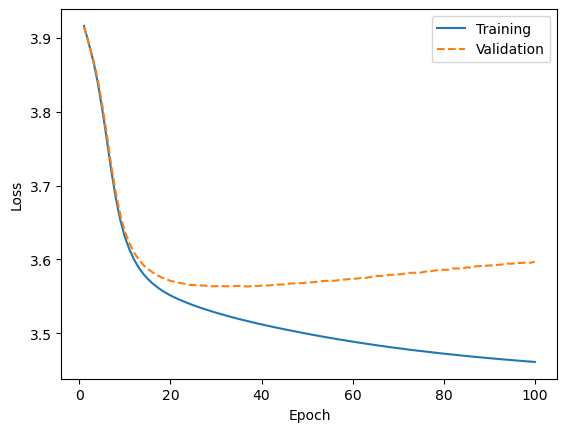

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Predicting test set survival curves

We begin by preprocessing the test data using the preprocessor built using training data.

In [ ]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor).astype('float32')

PyCox has built-in functionality for predicting survival functions:

In [ ]:
surv_test_np = deephit_model.predict_surv(X_test_np, batch_size=batch_size, to_cpu=True, numpy=True)
surv_test_np.shape

(2662, 109)

Note that the time grid used is precisely the one stored in `time_grid_train_np`:

In [ ]:
len(time_grid_train_np)

109

PyCox provides a helper function `predict_surv_df` that gets both the time grid and the predicted survival functions into a Pandas DataFrame. Note that for this DataFrame, the rows correspond to time and columns correspond to the different test points.

In [ ]:
surv_test_df = deephit_model.predict_surv_df(X_test_np, batch_size=batch_size)
surv_test_df

,0,1,2,3,4,5,6,7,8,9,...,2652,2653,2654,2655,2656,2657,2658,2659,2660,2661
0.0,0.999981,0.999319,0.999421,0.998916,0.999944,0.999988,0.999029,0.999091,0.999518,0.999997,...,0.999942,0.999892,0.998878,0.998989,0.999961,0.998592,0.999974,0.999376,0.997172,0.999805
3.0,0.966386,0.990079,0.989549,0.991190,0.986691,0.996840,0.990878,0.992223,0.994270,0.996848,...,0.989032,0.997803,0.991950,0.991956,0.997363,0.987516,0.996628,0.991377,0.988204,0.970640
4.0,0.872919,0.954802,0.972472,0.978045,0.965564,0.967528,0.976661,0.979665,0.980709,0.970878,...,0.972543,0.972053,0.978847,0.978636,0.982502,0.974065,0.962700,0.955129,0.974229,0.936413
5.0,0.820099,0.919456,0.958270,0.964234,0.953248,0.923308,0.965408,0.966981,0.963457,0.939818,...,0.960980,0.932772,0.963786,0.966515,0.963416,0.961725,0.910919,0.915803,0.960137,0.919683
6.0,0.744638,0.888553,0.949304,0.954284,0.944417,0.894503,0.956138,0.958616,0.953538,0.919636,...,0.952272,0.917319,0.953391,0.958142,0.952575,0.951420,0.872813,0.884279,0.947830,0.908099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599.0,0.260584,0.100707,0.116248,0.088784,0.337562,0.502196,0.103488,0.100280,0.135626,0.665883,...,0.341956,0.260377,0.090854,0.096821,0.439469,0.079623,0.386224,0.104125,0.061292,0.154872
1690.0,0.257719,0.093857,0.107055,0.079984,0.328262,0.498289,0.093525,0.091284,0.126850,0.663059,...,0.333463,0.255011,0.081370,0.087851,0.432493,0.069468,0.381994,0.098139,0.052284,0.145442
1760.0,0.251844,0.082882,0.098280,0.071199,0.320292,0.495036,0.079171,0.082216,0.120120,0.661010,...,0.326241,0.246574,0.074152,0.076273,0.426117,0.061536,0.376748,0.088860,0.042003,0.137495
1813.0,0.245281,0.071562,0.092644,0.064950,0.311957,0.486170,0.068015,0.075951,0.113942,0.655532,...,0.318321,0.237883,0.068123,0.068728,0.415024,0.055502,0.364445,0.079687,0.034986,0.132789


If you want to interpolate, PyCox provides the following interpolation functionality:

In [ ]:
# here we interpolate by a factor of 10 (so that if we initially had m time steps, we would now have (m-1)*10 + 1 time steps)
interpolation_factor = 10
surv_test_interp_df = deephit_model.interpolate(interpolation_factor).predict_surv_df(X_test_np, batch_size=batch_size)
surv_test_interp_df

,0,1,2,3,4,5,6,7,8,9,...,2652,2653,2654,2655,2656,2657,2658,2659,2660,2661
0.0,0.999981,0.999319,0.999421,0.998916,0.999944,0.999988,0.999029,0.999091,0.999518,0.999997,...,0.999942,0.999892,0.998878,0.998989,0.999961,0.998592,0.999974,0.999376,0.997172,0.999805
0.3,0.996622,0.998395,0.998434,0.998143,0.998619,0.999673,0.998214,0.998404,0.998993,0.999682,...,0.998851,0.999683,0.998186,0.998286,0.999701,0.997485,0.999639,0.998576,0.996275,0.996888
0.6,0.993262,0.997471,0.997447,0.997371,0.997293,0.999359,0.997399,0.997717,0.998468,0.999367,...,0.997760,0.999475,0.997493,0.997583,0.999441,0.996377,0.999305,0.997776,0.995378,0.993972
0.9,0.989903,0.996547,0.996460,0.996598,0.995968,0.999044,0.996584,0.997031,0.997944,0.999052,...,0.996669,0.999266,0.996800,0.996879,0.999181,0.995269,0.998970,0.996976,0.994481,0.991055
1.2,0.986543,0.995623,0.995472,0.995826,0.994643,0.998729,0.995768,0.996344,0.997419,0.998737,...,0.995578,0.999057,0.996107,0.996176,0.998922,0.994162,0.998635,0.996176,0.993585,0.988139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942.6,0.102042,0.034743,0.043012,0.032016,0.129998,0.198041,0.033382,0.036269,0.051427,0.264587,...,0.132473,0.100452,0.033074,0.033503,0.170541,0.028092,0.150072,0.037519,0.020077,0.059038
1964.2,0.078169,0.028607,0.034740,0.026527,0.099671,0.150019,0.027610,0.029655,0.041008,0.199429,...,0.101498,0.077547,0.027233,0.027632,0.129794,0.023524,0.114343,0.030491,0.017592,0.046746
1985.8,0.054296,0.022470,0.026468,0.021038,0.069345,0.101997,0.021838,0.023041,0.030589,0.134272,...,0.070524,0.054642,0.021392,0.021761,0.089047,0.018955,0.078614,0.023463,0.015107,0.034454
2007.4,0.030423,0.016334,0.018197,0.015549,0.039019,0.053976,0.016066,0.016428,0.020170,0.069114,...,0.039549,0.031737,0.015550,0.015890,0.048300,0.014387,0.042886,0.016435,0.012622,0.022162


In [ ]:
time_grid_train_interp_np = surv_test_interp_df.index.to_numpy()  # the interpolated time grid is an interpolated version of the *training*  time grid
surv_test_interp_np = surv_test_interp_df.to_numpy().T

We point out that if one did not want to create a Pandas DataFrame first, then the following code could be used instead to produce the same interpolated time grid and interpolated survival function:

```
surv_test_interp_np = deephit_model.interpolate(interpolation_factor).predict_surv(X_test_np, batch_size=batch_size, to_cpu=True, numpy=True)
from pycox.models.utils import make_subgrid
time_grid_train_interp_np = np.array(make_subgrid(time_grid_train_np, interpolation_factor))
```

Here's a plot of the predicted survival function for the 0th test data point:

Text(0, 0.5, 'Survival probability')

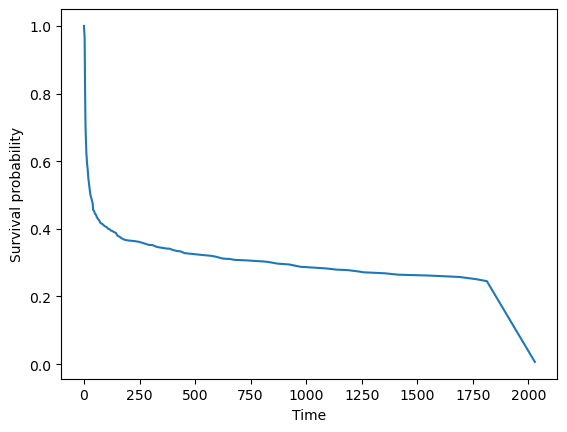

In [ ]:
plt.plot(time_grid_train_interp_np, surv_test_interp_np[0])
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Computing test set evaluation metrics

Here, we use the interpolated survival functions (along with their corresponding interpolated time grid).

As for choosing evaluation times, we still pick these based on the test set's observed times.

In [ ]:
time_grid_test_np = np.unique(Y_test_np)

Since DeepHit does not make the proportional hazards assumption and can predict survival curves without shape constraints, Harrell's concordance index (Harrell et al., 1982) is not a valid evaluation metric to use.

#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [ ]:
from pycox.evaluation import EvalSurv

eval_pycox = EvalSurv(surv_test_interp_df, Y_test_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')
print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.6088737721195845


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

In [ ]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(time_grid_test_np)),
                     int(.5 * len(time_grid_test_np)),
                     int(.75 * len(time_grid_test_np))]

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]

    # find the interpolated time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_interp_np))
    surv_values_at_eval_time_np = surv_test_interp_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 316.0 - truncated time-dependent concordance: 0.5952383597241816
Eval time 693.0 - truncated time-dependent concordance: 0.594074585623196
Eval time 1291.0 - truncated time-dependent concordance: 0.593412206245962


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

In [ ]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]

    # find the interpolated time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_interp_np))
    surv_values_at_eval_time_np = surv_test_interp_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 316.0 - time-dependent AUC: 0.6608183075900862
Eval time 693.0 - time-dependent AUC: 0.6946235312512404
Eval time 1291.0 - time-dependent AUC: 0.6953979312826533


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_interp_np, time_grid_train_interp_np,
                         Y_test_np, D_test_np,
                         Y_train_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(time_grid_test_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 316.0 - Brier score: 0.23129584902500178
Eval time 693.0 - Brier score: 0.2082869725085887
Eval time 1291.0 - Brier score: 0.18742686043310824
Integrated Brier score: 0.19032579653742368


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is not D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 598.4784722301928


In [ ]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 716.2569627330386


# Section 2.3.3: Nnet-survival Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to implement Nnet-survival (Gensheimer and Narasimhan, 2019) using PyCox and PyTorch. For an overview of Nnet-survival, please see Example 2.3.2 in Section 2.3.3 of the monograph. This demo is very similar to the DeepHit demo (`S2.3.3_DeepHit_single.ipynb`). Please look at the DeepHit demo first. In PyCox, Nnet-survival is implemented in the `LogisticHazard` Python class.

### Loading in the SUPPORT dataset (Knaus et al., 1995)

As with the earlier demo, we begin by defining the training, validation, and test sets.

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_np, D_full_train_np, \
        X_test_raw_np, Y_test_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('support')

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_np, Y_val_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 4968
Validation set size 1243
Test set size 2662

Features before preprocessing (14 total):
['age', 'female', 'race', 'num.co', 'diabetes', 'dementia', 'ca', 'meanbp', 'hrt', 'resp', 'temp', 'wblc', 'sod', 'crea']

Features after preprocessing (19 total):
['age_std', 'female', 'num.co_norm', 'diabetes', 'dementia', 'ca_norm', 'meanbp_std', 'hrt_std', 'resp_std', 'temp_std', 'wblc_std', 'sod_std', 'crea_std', 'race_blank', 'race_asian', 'race_black', 'race_hispanic', 'race_other', 'race_white']

Events: ['death']



We fit and apply a preprocessor to the training set. We apply (but do not re-fit) the preprocessor to the validation set.

In [ ]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Discretizing time

Time discretization works in the exact same way as in the DeepHit demo.

In [ ]:
import numpy as np
from pycox.preprocessing.label_transforms import LabTransDiscreteTime

num_time_steps = 128  # set this to 0 to use all unique times of death

if num_time_steps == 0:
    mask = (D_train_np == 1)  # boolean mask specifying which training patients experienced death
    label_transform = LabTransDiscreteTime(np.unique(Y_train_np[mask]))
else:
    # use a quantile based discretization, which could possibly end up using fewer than the
    # number of time steps requested (if it turns out that in the dataset, there are many
    # duplicate observed times)
    label_transform = LabTransDiscreteTime(num_time_steps, scheme='quantiles')

Y_train_discrete_np, D_train_discrete_np = label_transform.fit_transform(Y_train_np, D_train_np)
Y_val_discrete_np, D_val_discrete_np = label_transform.transform(Y_val_np, D_val_np)
# note: PyCox's discretization code allows for the possibility that the event indicator changes
# (if a patient's survival time is known so that the event indicator is 1, but the survival time
# is after the maximum discrete time grid time, then the patient's event indicator is changed to
# being censored)

time_grid_train_np = label_transform.cuts
output_num_time_steps = len(time_grid_train_np)
print(f'Number of time steps to be used with DeepHit: {output_num_time_steps}')
print('Time grid:', time_grid_train_np)

Number of time steps to be used with DeepHit: 109
Time grid: [   0.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.
   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.   26.
   27.   28.   30.   31.   33.   35.   37.   39.   41.   43.   45.   48.
   51.   54.   57.   59.   63.   66.   68.   73.   76.   82.   88.   92.
   97.  102.  108.  115.  120.  127.  135.  143.  151.  160.  167.  178.
  186.  198.  206.  217.  227.  236.  247.  261.  275.  292.  307.  328.
  344.  368.  384.  399.  417.  436.  452.  475.  496.  518.  539.  564.
  592.  624.  656.  678.  715.  757.  799.  827.  871.  923.  974. 1027.
 1085. 1131. 1184. 1228. 1258. 1345. 1415. 1530. 1599. 1690. 1760. 1813.
 2029.]


/home/george/Projects/survival-tutorial/pycox/preprocessing/discretization.py:37: UserWarning: cuts are not unique, continue with 109 cuts instead of 128
  warnings.warn(f"cuts are not unique, continue with {len(cuts)} cuts instead of {num}")


### Preparing training and validation sets for use with PyTorch

Note that at the time of writing, the code is a bit picky about the data types used. When evaluating the loss later, the underlying PyCox code needs the event indicators to be cast as float32 (unlike in the DeepHit demo).

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train_discrete_np, dtype=torch.int64, device=device)
D_train = torch.tensor(D_train_discrete_np, dtype=torch.float32, device=device)
train_data = list(zip(X_train, Y_train, D_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
Y_val = torch.tensor(Y_val_discrete_np, dtype=torch.int64, device=device)
D_val = torch.tensor(D_val_discrete_np, dtype=torch.float32, device=device)
val_data = list(zip(X_val, Y_val, D_val))

### Setting up the Nnet-survival model and loss

In [ ]:
import torch.nn as nn
from pycox.models import LogisticHazard

torch.manual_seed(0)

num_input_features = X_train.size(1)

base_neural_net = nn.Sequential(nn.Linear(num_input_features, 8),
                                nn.ReLU(),
                                nn.Linear(8, output_num_time_steps)).to(device)

nnetsurvival_model = LogisticHazard(base_neural_net, device=device,
                                    duration_index=time_grid_train_np)
nnetsurvival_loss = nnetsurvival_model.loss

### Training the model using minibatch gradient descent

Just as in the exponential time-to-event prediction model demo, we use the validation set to decide on whether to use a previous epoch's learned model parameters.

In [ ]:
from copy import deepcopy
from torch.utils.data import DataLoader

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 1e-2

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(base_neural_net.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    base_neural_net.train()
    for X_batch, Y_batch, D_batch in train_loader:
        neural_net_output = base_neural_net(X_batch)
        loss_batch = nnetsurvival_loss(neural_net_output, Y_batch, D_batch)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    base_neural_net.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            train_loss += nnetsurvival_loss(neural_net_output, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            val_loss += nnetsurvival_loss(neural_net_output, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(base_neural_net.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
base_neural_net.load_state_dict(best_params)

Epoch 1 - train loss 4.968472003936768 - val loss 4.938335418701172
Epoch 2 - train loss 3.9977524280548096 - val loss 3.996711015701294
Epoch 3 - train loss 3.8446109294891357 - val loss 3.8548760414123535
Epoch 4 - train loss 3.7577919960021973 - val loss 3.783118486404419
Epoch 5 - train loss 3.6902425289154053 - val loss 3.723034143447876
Epoch 6 - train loss 3.641087055206299 - val loss 3.6811790466308594
Epoch 7 - train loss 3.606241226196289 - val loss 3.652308225631714
Epoch 8 - train loss 3.58150577545166 - val loss 3.6336753368377686
Epoch 9 - train loss 3.564034938812256 - val loss 3.6228458881378174
Epoch 10 - train loss 3.550889015197754 - val loss 3.6081132888793945
Epoch 11 - train loss 3.540579319000244 - val loss 3.6052191257476807
Epoch 12 - train loss 3.5329127311706543 - val loss 3.59692645072937
Epoch 13 - train loss 3.525728464126587 - val loss 3.5962717533111572
Epoch 14 - train loss 3.520026922225952 - val loss 3.593959093093872
Epoch 15 - train loss 3.513835430

<All keys matched successfully>

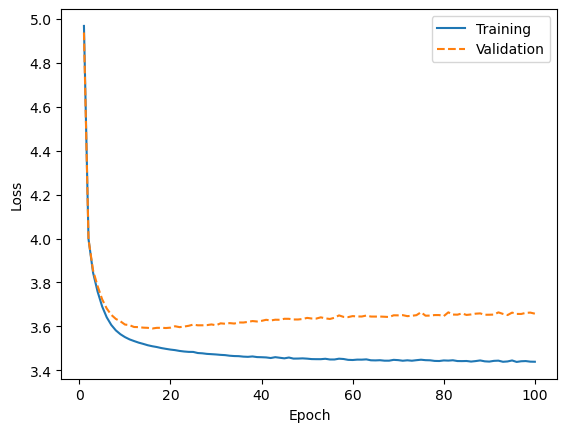

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Predicting test set survival curves

The code here is basically the same as in the DeepHit demo.

In [ ]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor).astype('float32')

We compute interpolated survival curves for the test set.

In [ ]:
# here we interpolate by a factor of 10 (so that if we initially had m time steps, we would now have (m-1)*10 + 1 time steps)
interpolation_factor = 10
surv_test_interp_df = nnetsurvival_model.interpolate(interpolation_factor).predict_surv_df(X_test_np, batch_size=batch_size)
time_grid_train_interp_np = surv_test_interp_df.index.to_numpy()  # the interpolated time grid is an interpolated version of the *training*  time grid
surv_test_interp_np = surv_test_interp_df.to_numpy().T

Here's a plot of the predicted survival function for the 0th test data point:

Text(0, 0.5, 'Survival probability')

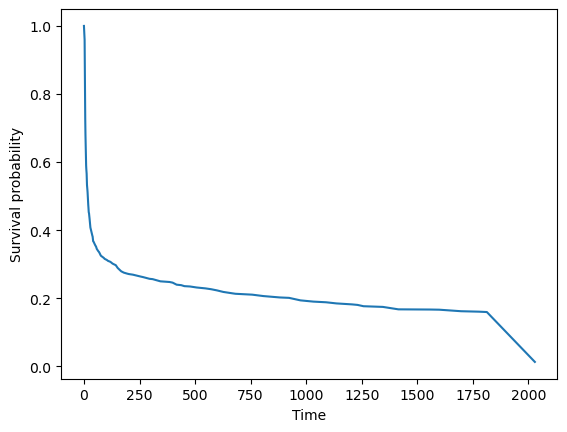

In [ ]:
plt.plot(time_grid_train_interp_np, surv_test_interp_np[0])
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Computing test set evaluation metrics

For choosing evaluation times, we use the test set's observed times.

In [ ]:
test_time_grid_np = np.unique(Y_test_np)

#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [ ]:
from pycox.evaluation import EvalSurv

eval_pycox = EvalSurv(surv_test_interp_df, Y_test_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')
print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.6058812636424377


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

In [ ]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(test_time_grid_np)),
                     int(.5 * len(test_time_grid_np)),
                     int(.75 * len(test_time_grid_np))]

for eval_time_index in eval_time_indices:
    eval_time = test_time_grid_np[eval_time_index]

    # find the interpolated time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_interp_np))
    surv_values_at_eval_time_np = surv_test_interp_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 316.0 - truncated time-dependent concordance: 0.5949681743892252
Eval time 693.0 - truncated time-dependent concordance: 0.5971409048872542
Eval time 1291.0 - truncated time-dependent concordance: 0.5961824163352452


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

In [ ]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = test_time_grid_np[eval_time_index]

    # find the interpolated time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_interp_np))
    surv_values_at_eval_time_np = surv_test_interp_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 316.0 - time-dependent AUC: 0.6511213558211291
Eval time 693.0 - time-dependent AUC: 0.684395583439373
Eval time 1291.0 - time-dependent AUC: 0.6791619083734639


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_interp_np, time_grid_train_interp_np,
                         Y_test_np, D_test_np,
                         Y_train_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(test_time_grid_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 316.0 - Brier score: 0.23204116850921025
Eval time 693.0 - Brier score: 0.20919962835759953
Eval time 1291.0 - Brier score: 0.19076235401204092
Integrated Brier score: 0.19155566452236197


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 615.1273008931904


In [ ]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 733.1180280653864


# Section 3.3: DeepSurv Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to implement DeepSurv (Faraggi and Simon, 1995; Katzman et al., 2018) using PyCox and PyTorch. For an overview of how DeepSurv works, please see Section 3.3 in the monograph. This demo largely builds off the exponential time-to-event prediction model demo (`S2.2.2_Exponential.ipynb`), so please look at that first as it describes the different steps of the experimental setup in more detail. In this demo, we specifically use PyCox's `CoxPH` model (which is a Python class), which--despite its name seeming to mean the classical Cox proportional hazards model--actually implements DeepSurv.

While this demo can be understood without first looking at the DeepHit demo (`S2.3.3_DeepHit_single.ipynb`), we think it could be helpful to also look at the DeepHit demo as a point of comparison--importantly, whereas DeepHit requires time to be discretized prior to model training, DeepSurv does not.

*Disclaimer:* Note that PyCox actually uses various conventions that are not standard in terms of working with PyTorch (it relies heavily on another package `torchtuples` by the same author as PyCox). Our demo here intentionally tries to stick to what would be considered standard PyTorch conventions (so that as a warning up front, what we present here does *not* perfectly align with the demos that come with PyCox but will more closely resemble how PyTorch is commonly used in many other settings, including for instance how model training works in TorchSurv). The key reason why we stick to standard PyTorch conventions is so that the code makes various preprocessing and model training steps more transparent, so that if you want to modify any part of these, it should be easier to do so (for instance, if you want to introduce a specific learning rate schedule, if you want to add early stopping based on a validation set integrated Brier score, if you want to control for randomness in a particular way using your own data loaders or specific random number generators, etc).

### Loading in the SUPPORT dataset (Knaus et al., 1995)

As with the earlier demo, we begin by defining the training, validation, and test sets.

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_np, D_full_train_np, \
        X_test_raw_np, Y_test_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('support')

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_np, Y_val_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 4968
Validation set size 1243
Test set size 2662

Features before preprocessing (14 total):
['age', 'female', 'race', 'num.co', 'diabetes', 'dementia', 'ca', 'meanbp', 'hrt', 'resp', 'temp', 'wblc', 'sod', 'crea']

Features after preprocessing (19 total):
['age_std', 'female', 'num.co_norm', 'diabetes', 'dementia', 'ca_norm', 'meanbp_std', 'hrt_std', 'resp_std', 'temp_std', 'wblc_std', 'sod_std', 'crea_std', 'race_blank', 'race_asian', 'race_black', 'race_hispanic', 'race_other', 'race_white']

Events: ['death']



We fit and apply a preprocessor to the training set. We apply (but do not re-fit) the preprocessor to the validation set.

In [ ]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Preparing training and validation sets for use with PyTorch

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train_np, dtype=torch.float32, device=device)
D_train = torch.tensor(D_train_np, dtype=torch.int32, device=device)
train_data = list(zip(X_train, Y_train, D_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
Y_val = torch.tensor(Y_val_np, dtype=torch.float32, device=device)
D_val = torch.tensor(D_val_np, dtype=torch.int32, device=device)
val_data = list(zip(X_val, Y_val, D_val))

### Setting up the DeepSurv model and loss

Note that the base neural net needs to output a single number corresponding to the log partial hazard function. There is no need to have a bias for the final linear layer since the bias would just get absorbed into the baseline hazard function.

In [ ]:
import torch.nn as nn
from pycox.models import CoxPH

torch.manual_seed(0)

num_input_features = X_train.size(1)

base_neural_net = nn.Sequential(nn.Linear(num_input_features, 8),
                                nn.ReLU(),
                                nn.Linear(8, 1, bias=False)).to(device)

deepsurv_model = CoxPH(base_neural_net, device=device)
deepsurv_loss = deepsurv_model.loss

### Step 1 of the training procedure in Section 3.3 of the monograph: Training the log partial hazards model using minibatch gradient descent

Just as in the exponential time-to-event prediction model demo, we use the validation set to decide on whether to use a previous epoch's learned model parameters.

In [ ]:
from copy import deepcopy
from torch.utils.data import DataLoader

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 1e-2

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(base_neural_net.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    base_neural_net.train()
    for X_batch, Y_batch, D_batch in train_loader:
        neural_net_output = base_neural_net(X_batch)
        loss_batch = deepsurv_loss(neural_net_output, Y_batch, D_batch)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    base_neural_net.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            train_loss += deepsurv_loss(neural_net_output, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            val_loss += deepsurv_loss(neural_net_output, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(base_neural_net.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
base_neural_net.load_state_dict(best_params)

Epoch 1 - train loss 4.232234954833984 - val loss 4.257750511169434
Epoch 2 - train loss 4.221454620361328 - val loss 4.250138759613037
Epoch 3 - train loss 4.219745635986328 - val loss 4.252907752990723
Epoch 4 - train loss 4.217616081237793 - val loss 4.248834609985352
Epoch 5 - train loss 4.2164740562438965 - val loss 4.2465410232543945
Epoch 6 - train loss 4.214822769165039 - val loss 4.243216514587402
Epoch 7 - train loss 4.215346336364746 - val loss 4.249841213226318
Epoch 8 - train loss 4.210739612579346 - val loss 4.241546630859375
Epoch 9 - train loss 4.209824562072754 - val loss 4.245884895324707
Epoch 10 - train loss 4.208444118499756 - val loss 4.243304252624512
Epoch 11 - train loss 4.208667278289795 - val loss 4.241664409637451
Epoch 12 - train loss 4.20735502243042 - val loss 4.240788459777832
Epoch 13 - train loss 4.206737518310547 - val loss 4.243132591247559
Epoch 14 - train loss 4.205790996551514 - val loss 4.24213171005249
Epoch 15 - train loss 4.204240322113037 - v

<All keys matched successfully>

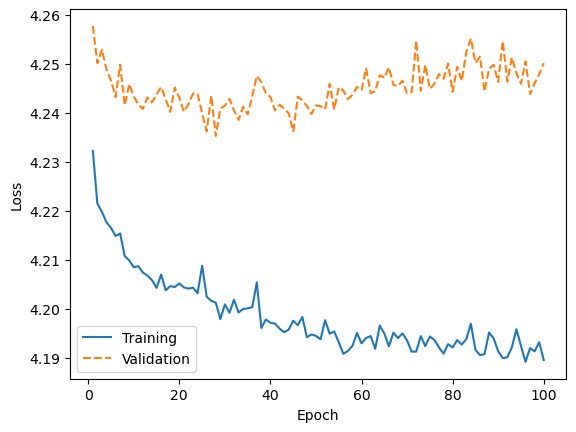

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Step 2 of the training procedure in Section 3.3 of the monograph: Fitting the baseline hazard function

Note that the discrete time grid used by PyCox is the unique times in `Y_train_np`.

In [ ]:
deepsurv_model.compute_baseline_hazards(input=X_train_np.astype('float32'),
                                        target=(Y_train_np.astype('float32'),
                                                D_train_np.astype('int32')))

duration
3.0       0.025753
4.0       0.054722
5.0       0.044133
6.0       0.036240
7.0       0.041364
            ...   
2024.0    0.000000
2026.0    0.000000
2027.0    0.000000
2028.0    0.000000
2029.0    0.000000
Name: baseline_hazards, Length: 1444, dtype: float64

### Predicting test set survival curves

We begin by preprocessing the test data using the preprocessor built using training data.

In [ ]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor).astype('float32')

PyCox has built-in functionality for predicting survival functions:

In [ ]:
surv_test_df = deepsurv_model.predict_surv_df(X_test_np, batch_size=batch_size)
surv_test_df

,0,1,2,3,4,5,6,7,8,9,...,2652,2653,2654,2655,2656,2657,2658,2659,2660,2661
duration,,,,,,,,,,,,,,,,,,,,,
3.0,0.973468,0.975779,0.987826,0.983264,0.987372,0.994474,0.986331,0.983465,0.986049,0.995728,...,0.989334,0.987810,0.983889,0.983533,0.992576,0.982749,0.983570,0.972109,0.982421,0.980892
4.0,0.919406,0.926243,0.962448,0.948626,0.961067,0.982834,0.957905,0.949234,0.957048,0.986711,...,0.967046,0.962399,0.950511,0.949436,0.976984,0.947074,0.949550,0.915399,0.946087,0.941492
5.0,0.878001,0.888131,0.942456,0.921581,0.940364,0.973546,0.935576,0.922496,0.934282,0.979498,...,0.949437,0.942382,0.924419,0.922801,0.964587,0.919249,0.922972,0.872082,0.917765,0.910873
6.0,0.845398,0.858010,0.926351,0.899951,0.923697,0.965985,0.917631,0.901105,0.915992,0.973614,...,0.935217,0.926257,0.903530,0.901489,0.954526,0.897012,0.901705,0.838050,0.895144,0.886476
7.0,0.809663,0.824876,0.908304,0.875882,0.905034,0.957426,0.897569,0.877294,0.895554,0.966942,...,0.919247,0.908188,0.880263,0.877764,0.943169,0.872287,0.878028,0.800825,0.870004,0.859426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024.0,0.033594,0.045311,0.213152,0.118845,0.201149,0.496961,0.176077,0.121962,0.169831,0.582582,...,0.258394,0.212717,0.128769,0.123017,0.390486,0.111244,0.123614,0.028161,0.106656,0.087619
2026.0,0.033594,0.045311,0.213152,0.118845,0.201149,0.496961,0.176077,0.121962,0.169831,0.582582,...,0.258394,0.212717,0.128769,0.123017,0.390486,0.111244,0.123614,0.028161,0.106656,0.087619
2027.0,0.033594,0.045311,0.213152,0.118845,0.201149,0.496961,0.176077,0.121962,0.169831,0.582582,...,0.258394,0.212717,0.128769,0.123017,0.390486,0.111244,0.123614,0.028161,0.106656,0.087619


In [ ]:
surv_test_np = surv_test_df.to_numpy().T
time_grid_train_np = surv_test_df.index.to_numpy()

Here's a plot of the predicted survival function for the 0th test data point:

Text(0, 0.5, 'Survival probability')

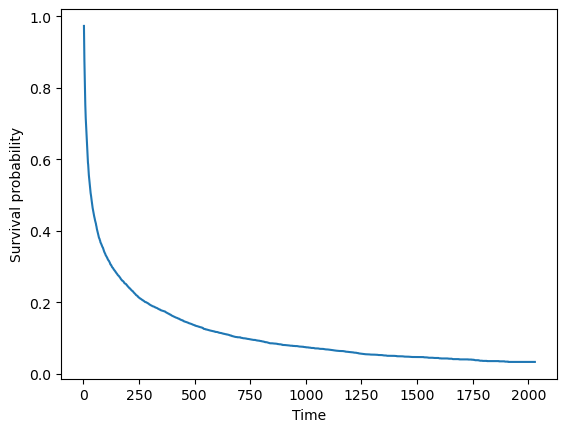

In [ ]:
plt.plot(time_grid_train_np, surv_test_np[0])
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Computing test set evaluation metrics

For choosing evaluation times, we use the test set's observed times.

In [ ]:
import numpy as np
time_grid_test_np = np.unique(Y_test_np)

#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [ ]:
from pycox.evaluation import EvalSurv

eval_pycox = EvalSurv(surv_test_df, Y_test_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')
print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.610701496709868


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

In [ ]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(time_grid_test_np)),
                     int(.5 * len(time_grid_test_np)),
                     int(.75 * len(time_grid_test_np))]

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]

    # find the training time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_np))
    surv_values_at_eval_time_np = surv_test_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 316.0 - truncated time-dependent concordance: 0.6061113486082409
Eval time 693.0 - truncated time-dependent concordance: 0.6110931896771314
Eval time 1291.0 - truncated time-dependent concordance: 0.6117946842068762


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

In [ ]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]

    # find the training time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_np))
    surv_values_at_eval_time_np = surv_test_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 316.0 - time-dependent AUC: 0.6653015691699965
Eval time 693.0 - time-dependent AUC: 0.6999602190340523
Eval time 1291.0 - time-dependent AUC: 0.7079045183054151


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_np, time_grid_train_np,
                         Y_test_np, D_test_np,
                         Y_train_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(time_grid_test_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 316.0 - Brier score: 0.2280812189176826


/home/george/anaconda3/lib/python3.12/site-packages/SurvivalEVAL/Evaluator.py:59: UserWarning: The first time coordinate is not 0. A authentic survival curve should start from 0 with 100% survival probability. \Adding 0 to the beginning of the time coordinates and 1 to the beginning of the predicted curves.
  warnings.warn("The first time coordinate is not 0. "


Eval time 693.0 - Brier score: 0.20567825100918427
Eval time 1291.0 - Brier score: 0.18449317051788744
Integrated Brier score: 0.1854886838100155


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is not D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 615.0655919527228


In [ ]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 720.8059698432095


# Section 3.4: Cox-Time Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to implement Cox-Time (Kvamme et al., 2019) using PyCox and PyTorch. For an overview of how Cox-Time works, please see Section 3.4 of the monograph. This Cox-Time demo builds off the DeepSurv demo (`S3.3_DeepSurv.ipynb`), so please look at that first. We again use PyCox, where the Cox-Time model is defined as the `CoxTime` Python class.

Extremely importantly, unlike how DeepSurv is implemented in PyCox, the Cox-Time implementation in PyCox uses a stochastic so-called "case-control" approximation of the loss function. Please see the paper by Kvamme et al. (2019) for details. This approximation leads to some dramatic differences in various parts of the code here (compared to our DeepSurv demo).

### Loading in the SUPPORT dataset (Knaus et al., 1995)

As with the earlier demo, we begin by defining the training, validation, and test sets.

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_raw_np, D_full_train_np, \
        X_test_raw_np, Y_test_raw_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('support')

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_raw_np, Y_val_raw_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_raw_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 4968
Validation set size 1243
Test set size 2662

Features before preprocessing (14 total):
['age', 'female', 'race', 'num.co', 'diabetes', 'dementia', 'ca', 'meanbp', 'hrt', 'resp', 'temp', 'wblc', 'sod', 'crea']

Features after preprocessing (19 total):
['age_std', 'female', 'num.co_norm', 'diabetes', 'dementia', 'ca_norm', 'meanbp_std', 'hrt_std', 'resp_std', 'temp_std', 'wblc_std', 'sod_std', 'crea_std', 'race_blank', 'race_asian', 'race_black', 'race_hispanic', 'race_other', 'race_white']

Events: ['death']



We fit and apply a preprocessor to the training set. We apply (but do not re-fit) the preprocessor to the validation set.

In [ ]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Preparing training and validation sets for use with PyTorch

Because time is treated as an additional input to the neural network later, how time is scaled now matters. PyCox comes with a way to standardize time.

In [ ]:
import torch
from pycox.models import CoxTime
from pycox.models.data import CoxTimeDataset

label_transform = CoxTime.label_transform()

# the code is written so that the event indicators get transformed too but they
# actually remain the same but are cast as float32
Y_train_np, D_train_np = label_transform.fit_transform(Y_train_raw_np, D_train_np)
Y_val_np, D_val_np = label_transform.transform(Y_val_raw_np, D_val_np)

Currently, PyCox requires a more complicated way of loading in data for `CoxTime`. PyCox is written so that this part of the code is "under the hood" so to speak so that if one follows the conventions of PyCox, then this sort of code does not have to be written by the user. However, since we are trying to present PyTorch models in a unified way that follows standard PyTorch conventions, we will expose some of this "under the hood" code.

To construct the dataset for use with PyTorch's DataLoader, we use the `CoxTimeDataset` class but using this requires first sorting the data by observed times. The reason why this sorting is needed by the code is that per data point (which we call the "case" point), we are going to randomly sample a "control" point (where the control point needs to have an observed time at least that of the case point). By sorting the data by observed times, it is computationally faster to figure out what are eligible control points per case point.

This "case-control" idea is used in approximating the Cox-Time loss function. Because the validation set is used for setting hyperparameter(s), and in this demo, we use the same case-control loss on the validation set, as recommended in the original PyCox Cox-Time demo, we can simply replicate the validation data multiple times to reduce variance on the validation loss values (specifically, the variance that is introduced due to the randomly sampling of control points per case point).

Note that there would be no need to use this replication strategy for the validation set if we used a different evaluation metric on the validation set that does not involve some approximation.

In [ ]:
import numpy as np

np.random.seed(0)
torch.manual_seed(0)

train_sort_indices = np.argsort(Y_train_np)
train_data = CoxTimeDataset(X_train_np[train_sort_indices].astype('float32'),
                            Y_train_np[train_sort_indices].astype('float32'),
                            D_train_np[train_sort_indices].astype('int32'))

num_val_set_repeats = 5
X_val_repeated_np = np.tile(X_val_np, (num_val_set_repeats, 1))
Y_val_repeated_np = np.tile(Y_val_np, num_val_set_repeats)
D_val_repeated_np = np.tile(D_val_np, num_val_set_repeats)

val_sort_indices = np.argsort(Y_val_np)
val_data = CoxTimeDataset(X_val_repeated_np[val_sort_indices].astype('float32'),
                          Y_val_repeated_np[val_sort_indices].astype('float32'),
                          D_val_repeated_np[val_sort_indices].astype('int32'))

### Setting up the Cox-Time model and loss

In [ ]:
import torch.nn as nn
from pycox.models import CoxTime

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_input_features = X_train_np.shape[1] + 1  # add 1 more for time
base_neural_net = nn.Sequential(nn.Linear(num_input_features, 8),
                                nn.ReLU(),
                                nn.Linear(8, 1)).to(device)

# PyCox's CoxTime expects the base neural net's forward function to take in two
# separate inputs: the features and time (take a look at the forward function)
class CoxTimeBaseNeuralNetWrapper(nn.Module):
    def __init__(self, base_neural_net):
        super(CoxTimeBaseNeuralNetWrapper, self).__init__()
        self.net = base_neural_net

    def forward(self, inputs_excluding_times, times):
        inputs = torch.cat([inputs_excluding_times, times], dim=1)
        return self.net(inputs)

base_neural_net_wrapper = CoxTimeBaseNeuralNetWrapper(base_neural_net)

# specifying the label transform is important since for prediction, we basically
# need to be able to undo the standardization of time (this code is done under
# the hood by PyCox so that we don't have to worry about it, but we do need to
# specify the label transform!)
coxtime_model = CoxTime(base_neural_net_wrapper, device=device, labtrans=label_transform)
coxtime_loss = coxtime_model.loss

### Step 1 of the training procedure in Section 3.4 of the monograph: Training the log partial hazards model using minibatch gradient descent

Just as in the exponential time-to-event prediction model demo, we use the validation set to decide on whether to use a previous epoch's learned model parameters.

In [ ]:
from copy import deepcopy
from torch.utils.data import DataLoader

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 1e-3

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(base_neural_net.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    base_neural_net.train()
    for case, controls in train_loader:
        case_X_batch = case[0].squeeze(1).to(device)
        case_Y_batch = case[1].squeeze(1).to(device)
        case_neural_net_output = base_neural_net_wrapper(case_X_batch, case_Y_batch)

        control_X_batch = controls[0][0].squeeze(1).to(device)
        control_Y_batch = controls[0][1].squeeze(1).to(device)
        control_neural_net_output = base_neural_net_wrapper(control_X_batch, control_Y_batch)

        loss_batch = coxtime_loss(case_neural_net_output,
                                  control_neural_net_output)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    base_neural_net.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for case, controls in train_loader:
            case_X_batch = case[0].squeeze(1).to(device)
            case_Y_batch = case[1].squeeze(1).to(device)
            case_neural_net_output = base_neural_net_wrapper(case_X_batch, case_Y_batch)

            control_X_batch = controls[0][0].squeeze(1).to(device)
            control_Y_batch = controls[0][1].squeeze(1).to(device)
            control_neural_net_output = base_neural_net_wrapper(control_X_batch, control_Y_batch)

            batch_num_points = case_X_batch.size(0)
            train_loss += coxtime_loss(case_neural_net_output,
                                       control_neural_net_output) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for case, controls in val_loader:
            case_X_batch = case[0].squeeze(1).to(device)
            case_Y_batch = case[1].squeeze(1).to(device)
            case_neural_net_output = base_neural_net_wrapper(case_X_batch, case_Y_batch)

            control_X_batch = controls[0][0].squeeze(1).to(device)
            control_Y_batch = controls[0][1].squeeze(1).to(device)
            control_neural_net_output = base_neural_net_wrapper(control_X_batch, control_Y_batch)

            batch_num_points = case_X_batch.size(0)
            val_loss += coxtime_loss(case_neural_net_output,
                                     control_neural_net_output) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(base_neural_net.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
base_neural_net.load_state_dict(best_params)

Epoch 1 - train loss 0.6940743327140808 - val loss 0.6938080191612244
Epoch 2 - train loss 0.6907305121421814 - val loss 0.6922503709793091
Epoch 3 - train loss 0.6869921684265137 - val loss 0.693767249584198
Epoch 4 - train loss 0.6828335523605347 - val loss 0.6869940161705017
Epoch 5 - train loss 0.6803634166717529 - val loss 0.6863062381744385
Epoch 6 - train loss 0.6770353317260742 - val loss 0.6803102493286133
Epoch 7 - train loss 0.6748912334442139 - val loss 0.6831167340278625
Epoch 8 - train loss 0.6687607765197754 - val loss 0.671286940574646
Epoch 9 - train loss 0.6656661033630371 - val loss 0.6715031862258911
Epoch 10 - train loss 0.6609587073326111 - val loss 0.6744487285614014
Epoch 11 - train loss 0.6567094326019287 - val loss 0.6699622273445129
Epoch 12 - train loss 0.6595966219902039 - val loss 0.6731348037719727
Epoch 13 - train loss 0.6541621685028076 - val loss 0.6562591791152954
Epoch 14 - train loss 0.6554439067840576 - val loss 0.6708393692970276
Epoch 15 - train 

<All keys matched successfully>

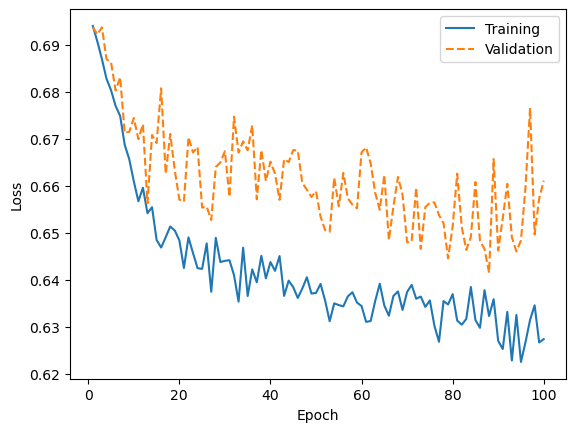

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Step 2 of the training procedure in Section 3.3 of the monograph: Fitting the baseline hazard function

In [ ]:
coxtime_model.compute_baseline_hazards(input=X_train_np[train_sort_indices].astype('float32'),
                                       target=(Y_train_np[train_sort_indices].astype('float32'),
                                               D_train_np[train_sort_indices].astype('int32')))

duration
-0.849806    0.011853
-0.848020    0.025289
-0.846234    0.020463
-0.844448    0.016839
-0.842663    0.019238
               ...   
 2.759273    0.000000
 2.762845    0.000000
 2.764631    0.000000
 2.766416    0.000000
 2.768202    0.000000
Name: baseline_hazards, Length: 1444, dtype: float64

### Predicting test set survival curves

We begin by preprocessing the test data using the preprocessor built using training data.

In [ ]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor).astype('float32')

PyCox has built-in functionality for predicting survival functions:

In [ ]:
# predict on the test data
surv_test_df = coxtime_model.predict_surv_df(X_test_np, batch_size=batch_size)
surv_test_df

,0,1,2,3,4,5,6,7,8,9,...,2652,2653,2654,2655,2656,2657,2658,2659,2660,2661
3.0,0.975527,0.971226,0.986582,0.985967,0.992237,0.993656,0.987768,0.984490,0.983593,0.995660,...,0.993348,0.986660,0.985934,0.985451,0.992206,0.985539,0.982198,0.975042,0.980223,0.984665
4.0,0.925340,0.912610,0.958521,0.956666,0.975860,0.980268,0.962157,0.952160,0.949463,0.986470,...,0.979287,0.958791,0.956548,0.955115,0.975795,0.955372,0.945294,0.923868,0.939294,0.952692
5.0,0.886662,0.867809,0.936375,0.933581,0.962795,0.969577,0.941911,0.926751,0.922699,0.979101,...,0.968043,0.936816,0.933387,0.931256,0.962728,0.931631,0.916470,0.884443,0.907405,0.927554
6.0,0.856075,0.832620,0.918516,0.914992,0.952166,0.960874,0.925563,0.906328,0.901230,0.973082,...,0.958876,0.919111,0.914728,0.912071,0.952117,0.912532,0.893426,0.853274,0.881958,0.907343
7.0,0.822449,0.794184,0.898505,0.894195,0.940154,0.951036,0.907223,0.883519,0.877297,0.966256,...,0.948498,0.899292,0.893842,0.890637,0.940148,0.891182,0.867824,0.819015,0.853733,0.884766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024.0,0.133155,0.067722,0.058571,0.067082,0.297822,0.555476,0.118620,0.043564,0.062233,0.682629,...,0.315506,0.234961,0.077004,0.073027,0.477943,0.100319,0.204064,0.073566,0.053128,0.056805
2026.0,0.133155,0.067722,0.058571,0.067082,0.297822,0.555476,0.118620,0.043564,0.062233,0.682629,...,0.315506,0.234961,0.077004,0.073027,0.477943,0.100319,0.204064,0.073566,0.053128,0.056805
2027.0,0.133155,0.067722,0.058571,0.067082,0.297822,0.555476,0.118620,0.043564,0.062233,0.682629,...,0.315506,0.234961,0.077004,0.073027,0.477943,0.100319,0.204064,0.073566,0.053128,0.056805
2028.0,0.133155,0.067722,0.058571,0.067082,0.297822,0.555476,0.118620,0.043564,0.062233,0.682629,...,0.315506,0.234961,0.077004,0.073027,0.477943,0.100319,0.204064,0.073566,0.053128,0.056805


In [ ]:
surv_test_np = surv_test_df.to_numpy().T
time_grid_train_np = surv_test_df.index.to_numpy()

Here's a plot of the predicted survival function for the 0th test data point:

Text(0, 0.5, 'Survival probability')

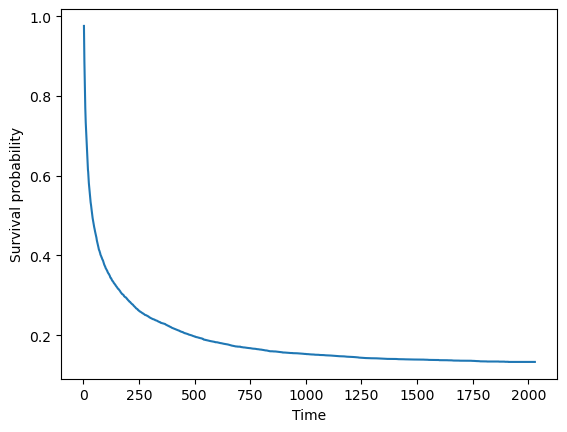

In [ ]:
plt.plot(time_grid_train_np, surv_test_np[0])
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Computing test set evaluation metrics

For choosing evaluation times, we use the test set's observed times.

In [ ]:
import numpy as np
time_grid_test_np = np.unique(Y_test_raw_np)

#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [ ]:
from pycox.evaluation import EvalSurv

eval_pycox = EvalSurv(surv_test_df, Y_test_raw_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')
print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.6240042464655366


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

In [ ]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_raw_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_raw_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(time_grid_test_np)),
                     int(.5 * len(time_grid_test_np)),
                     int(.75 * len(time_grid_test_np))]

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]

    # find the training time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_np))
    surv_values_at_eval_time_np = surv_test_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 316.0 - truncated time-dependent concordance: 0.6189888690092046
Eval time 693.0 - truncated time-dependent concordance: 0.6187114738437648
Eval time 1291.0 - truncated time-dependent concordance: 0.6131850274105245


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

In [ ]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]

    # find the training time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_np))
    surv_values_at_eval_time_np = surv_test_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 316.0 - time-dependent AUC: 0.6773695695704807
Eval time 693.0 - time-dependent AUC: 0.7078085799435507
Eval time 1291.0 - time-dependent AUC: 0.7156318714962631


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_np, time_grid_train_np,
                         Y_test_raw_np, D_test_np,
                         Y_train_raw_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(time_grid_test_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 316.0 - Brier score: 0.2251993309459064


/home/george/anaconda3/lib/python3.12/site-packages/SurvivalEVAL/Evaluator.py:59: UserWarning: The first time coordinate is not 0. A authentic survival curve should start from 0 with 100% survival probability. \Adding 0 to the beginning of the time coordinates and 1 to the beginning of the predicted curves.
  warnings.warn("The first time coordinate is not 0. "


Eval time 693.0 - Brier score: 0.20330428701752654
Eval time 1291.0 - Brier score: 0.1824185628210795
Integrated Brier score: 0.1838463858192865


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 623.4871936754847


In [ ]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 721.5713689377704


# Section 4.3: Survival Kernets Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to implement survival kernets (Chen, 2024) using PyTorch and PyCox (Chen's original code is written based on existing PyCox code). For an overview of survival kernets, please see Section 4.3 in the monograph. This demo is very similar to the DeepHit demo (`S2.3.3_DeepHit_single.ipynb`). Please look at the DeepHit demo first.

Note that the code for survival kernets in some sense supersedes the earlier deep kernel survival analysis (DKSA) model by Chen (2020)--covered in Section 4.2 of the monograph--since it is possible to set hyperparameters for survival kernets and set up the warm-start in a way that we recover the original DKSA approach.

The base neural network in this case is used to help compute a kernel function (i.e., a function that gives a similarity score between 0 and 1 for any two pairs of data points; a higher similarity score means that the two points are considered more similar).

Model training works as follows:

1. We first train an XGBoost model. The XGBoost model's predicted leaves for the data points are then used to warm-start base neural network training. Chen (2024) refers to this step as the "Tree ensemble Under a Neural Approximation" (TUNA) warm-start.
2. We then continue to train the base neural network using a negative log likelihood loss + a ranking loss (similar to DeepHit).
3. Finally, treating the base neural network as fixed (so that the kernel function is treated as fixed), we now treat the different exemplar/cluster summary functions as parameters that can be optimized (rather than having them be determined based on a Kaplan-Meier calculation). Chen (2024) refers to this step as "summary fine-tuning".

### Loading in the SUPPORT dataset (Knaus et al., 1995)

As with the earlier demo, we begin by defining the training, validation, and test sets.

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_np, D_full_train_np, \
        X_test_raw_np, Y_test_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('support')

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_np, Y_val_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 4968
Validation set size 1243
Test set size 2662

Features before preprocessing (14 total):
['age', 'female', 'race', 'num.co', 'diabetes', 'dementia', 'ca', 'meanbp', 'hrt', 'resp', 'temp', 'wblc', 'sod', 'crea']

Features after preprocessing (19 total):
['age_std', 'female', 'num.co_norm', 'diabetes', 'dementia', 'ca_norm', 'meanbp_std', 'hrt_std', 'resp_std', 'temp_std', 'wblc_std', 'sod_std', 'crea_std', 'race_blank', 'race_asian', 'race_black', 'race_hispanic', 'race_other', 'race_white']

Events: ['death']



We fit and apply a preprocessor to the training set. We apply (but do not re-fit) the preprocessor to the validation set.

In [ ]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Warm-start: Tree ensemble Under a Neural Approximation (TUNA)

The original deep kernel survival analysis paper (Chen, 2020) found warm-starting neural net training with random survival forests (Ishwaran et al., 2008) to be helpful (typically better than using standard neural net random parameter initialization). The problem is that random survival forests do not scale well to very large datasets. Chen (2024) subsequently showed how to instead use XGBoost (Chen and Guestrin, 2016) to warm-start neural net training. Note that XGBoost scales to very large datasets and also supports survival analysis.

#### Training an XGBoost model to help with warm-starting base neural net training

We begin by training an XGBoost model. For simplicity, we do not tune the hyperparameters of this XGBoost model aside from the number of rounds/trees used (where we use XGBoost's built-in early stopping functionality). In practice, one should try to tune this XGBoost model to make it as good as possible by, for instance, tuning hyperparameters using the validation set &mdash; no peeking at the test set of course. XGBoost's built-in early-stopping just uses whichever loss function we ask it to use, in this case the Cox loss. In practice, one could instead use a different validation set loss (for instance, Chen's XGBoost demo code evaluates Harrell's concordance index on the validation set to decide on how many iterations/trees to use: https://github.com/georgehc/survival-kernets/blob/main/demo_xgb.py).

In [ ]:
import xgboost as xgb

# for the Cox model, XGBoost expects censored observations to be specified as negative
train_data_xgb = xgb.DMatrix(X_train_np,
                             label=Y_train_np * (2*(D_train_np - 0.5)))
val_data_xgb = xgb.DMatrix(X_val_np,
                           label=Y_val_np * (2*(D_val_np - 0.5)))

# note that there are many other hyperparameters that can be tuned -- see the XGBoost documentation for details
xgb_params = {'seed': 0,
              'eta': .1,
              'objective': 'survival:cox'}
max_num_rounds = 100
early_stopping = 10

xgb_model = xgb.train(xgb_params, train_data_xgb, max_num_rounds,
                      early_stopping_rounds=early_stopping,
                      evals=[(val_data_xgb, 'val')])

[0]	val-cox-nloglik:6.59471
[1]	val-cox-nloglik:6.58534
[2]	val-cox-nloglik:6.57637
[3]	val-cox-nloglik:6.57156
[4]	val-cox-nloglik:6.56784
[5]	val-cox-nloglik:6.56498
[6]	val-cox-nloglik:6.56092
[7]	val-cox-nloglik:6.55869
[8]	val-cox-nloglik:6.56051
[9]	val-cox-nloglik:6.55782
[10]	val-cox-nloglik:6.55753
[11]	val-cox-nloglik:6.55430
[12]	val-cox-nloglik:6.55883
[13]	val-cox-nloglik:6.55797
[14]	val-cox-nloglik:6.55716
[15]	val-cox-nloglik:6.55791
[16]	val-cox-nloglik:6.55852
[17]	val-cox-nloglik:6.56349
[18]	val-cox-nloglik:6.56910
[19]	val-cox-nloglik:6.57237
[20]	val-cox-nloglik:6.58053


To use the warm-start approach by Chen (2024), we need to know which tree leaves the different training and validation points get predicted to be in. XGBoost provides this functionality as follows:

In [ ]:
xgb_leaves_train = xgb_model.predict(train_data_xgb,
                                     iteration_range=(0, xgb_model.best_iteration + 1),
                                     pred_leaf=True)
xgb_leaves_val = xgb_model.predict(val_data_xgb,
                                   iteration_range=(0, xgb_model.best_iteration + 1),
                                   pred_leaf=True)

We'll see how these leaves are used next.

#### Prepare training and validation data for TUNA

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
leaves_train = torch.tensor(xgb_leaves_train, dtype=torch.float32, device=device)
tuna_train_data = list(zip(X_train, leaves_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
leaves_val = torch.tensor(xgb_leaves_val, dtype=torch.float32, device=device)
tuna_val_data = list(zip(X_val, leaves_val))

#### Set up the base neural net (not just for the TUNA warm-start---we keep training it after the warm-start)

In [ ]:
import torch.nn as nn
from survival_kernets.models import Hypersphere

torch.manual_seed(0)

num_input_features = X_train.size(1)
base_neural_net = nn.Sequential(nn.Linear(num_input_features, 16),
                                nn.ReLU(),
                                nn.Linear(16, 16),
                                Hypersphere(squared_radius=0.1)).to(device)

#### Set up the TUNA loss

Which leaves the data points are predicted to be in are used to compute a target kernel matrix.

The neural net's output could also be used to generate a predicted kernel matrix.

We simply ask that the predicted and target kernel matrices are close in terms of MSE loss.

In [ ]:
import torch.nn.functional as F
from survival_kernets.models import symmetric_squared_pairwise_distances

def tuna_loss(neural_net_output, leaves_batch):
    predicted_kernel_matrix = \
        (-symmetric_squared_pairwise_distances(neural_net_output)).exp() \
         - torch.eye(neural_net_output.size(0), device=device)
    target_kernel_matrix = \
        (1. - torch.cdist(leaves_batch, leaves_batch, 0) / leaves_batch.size(1)).view(-1)
    return F.mse_loss(predicted_kernel_matrix.view(-1), target_kernel_matrix.view(-1))

#### TUNA minibatch gradient descent

In [ ]:
from copy import deepcopy
from torch.utils.data import DataLoader

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 1e-1

tuna_train_loader = DataLoader(tuna_train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
tuna_val_loader = DataLoader(tuna_val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(base_neural_net.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    base_neural_net.train()
    for X_batch, leaves_batch in tuna_train_loader:
        neural_net_output = base_neural_net(X_batch)
        loss_batch = tuna_loss(neural_net_output, leaves_batch)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    base_neural_net.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, leaves_batch in tuna_train_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            train_loss += tuna_loss(neural_net_output, leaves_batch) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, leaves_batch in tuna_val_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            val_loss += tuna_loss(neural_net_output, leaves_batch) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(base_neural_net.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
base_neural_net.load_state_dict(best_params)

Epoch 1 - train loss 0.020665979012846947 - val loss 0.021243002265691757
Epoch 2 - train loss 0.018862249329686165 - val loss 0.01920282654464245
Epoch 3 - train loss 0.01741189695894718 - val loss 0.017763640731573105
Epoch 4 - train loss 0.017038807272911072 - val loss 0.017298027873039246
Epoch 5 - train loss 0.01647206023335457 - val loss 0.016931984573602676
Epoch 6 - train loss 0.016326095908880234 - val loss 0.01659383624792099
Epoch 7 - train loss 0.016163984313607216 - val loss 0.016638632863759995
Epoch 8 - train loss 0.016125136986374855 - val loss 0.016618166118860245
Epoch 9 - train loss 0.015812942758202553 - val loss 0.016302917152643204
Epoch 10 - train loss 0.01581600308418274 - val loss 0.01629641093313694
Epoch 11 - train loss 0.01570870541036129 - val loss 0.016079997643828392
Epoch 12 - train loss 0.015451312065124512 - val loss 0.015938090160489082
Epoch 13 - train loss 0.015308879315853119 - val loss 0.015848958864808083
Epoch 14 - train loss 0.01537502370774746

<All keys matched successfully>

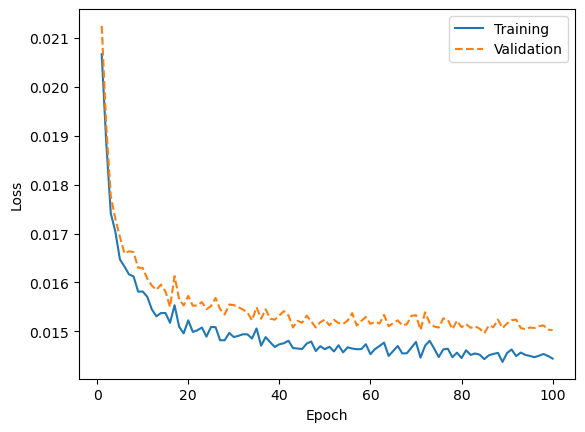

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

At this point, we're done with the warm-starting portion of base neural net training.

### Discretizing time

Before continuing to train the base neural net with a survival loss in PyTorch, we now discrete time just like in the DeepHit demo.

In [ ]:
import numpy as np
from pycox.preprocessing.label_transforms import LabTransDiscreteTime

num_time_steps = 128  # set this to 0 to use all unique times of death

if num_time_steps == 0:
    mask = (D_train_np == 1)  # boolean mask specifying which training patients experienced death
    label_transform = LabTransDiscreteTime(np.unique(Y_train_np[mask]))
else:
    # use a quantile based discretization, which could possibly end up using fewer than the
    # number of time steps requested (if it turns out that in the dataset, there are many
    # duplicate observed times)
    label_transform = LabTransDiscreteTime(num_time_steps, scheme='quantiles')

Y_train_discrete_np, D_train_discrete_np = label_transform.fit_transform(Y_train_np, D_train_np)
Y_val_discrete_np, D_val_discrete_np = label_transform.transform(Y_val_np, D_val_np)
# note: PyCox's discretization code allows for the possibility that the event indicator changes
# (if a patient's survival time is known so that the event indicator is 1, but the survival time
# is after the maximum discrete time grid time, then the patient's event indicator is changed to
# being censored)

time_grid_train_np = label_transform.cuts
output_num_time_steps = len(time_grid_train_np)
print(f'Number of time steps to be used with DeepHit: {output_num_time_steps}')
print('Time grid:', time_grid_train_np)

Number of time steps to be used with DeepHit: 109
Time grid: [   0.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.   13.
   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.   26.
   27.   28.   30.   31.   33.   35.   37.   39.   41.   43.   45.   48.
   51.   54.   57.   59.   63.   66.   68.   73.   76.   82.   88.   92.
   97.  102.  108.  115.  120.  127.  135.  143.  151.  160.  167.  178.
  186.  198.  206.  217.  227.  236.  247.  261.  275.  292.  307.  328.
  344.  368.  384.  399.  417.  436.  452.  475.  496.  518.  539.  564.
  592.  624.  656.  678.  715.  757.  799.  827.  871.  923.  974. 1027.
 1085. 1131. 1184. 1228. 1258. 1345. 1415. 1530. 1599. 1690. 1760. 1813.
 2029.]


/home/george/Projects/survival-tutorial/pycox/preprocessing/discretization.py:37: UserWarning: cuts are not unique, continue with 109 cuts instead of 128
  warnings.warn(f"cuts are not unique, continue with {len(cuts)} cuts instead of {num}")


### Preparing training and validation sets for use with PyTorch

Note that at this point the observed times have been converted into discrete indices. Note that at the time of writing, the code is a bit picky about the data types used. When evaluating the loss later, the underlying PyCox code needs the event indicators to be cast as float32 (unlike in the DeepHit demo).

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train_discrete_np, dtype=torch.int64, device=device)
D_train = torch.tensor(D_train_discrete_np, dtype=torch.int32, device=device)
train_data = list(zip(X_train, Y_train, D_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
Y_val = torch.tensor(Y_val_discrete_np, dtype=torch.int64, device=device)
D_val = torch.tensor(D_val_discrete_np, dtype=torch.int32, device=device)
val_data = list(zip(X_val, Y_val, D_val))

### Setting up the survival kernets model and loss

In [ ]:
from survival_kernets.models import NKS

# - alpha and sigma hyperparameters mean the same as what they mean for the DeepHit loss
# - tau refers to the distance threshold in the embedding space
# - beta indicates how much compression to use for the training data
#   (beta = 0 means no compression, which corresponds to the original deep kernel
#    survival analysis method by Chen (2020) with the only difference being the
#    distance thresholding by tau, and the use of XGBoost instead of a random
#    survival forest warm start; as beta gets larger, we compress more so that
#    there are fewer and fewer exemplars/clusters)
min_kernel_weight = 1e-2  # only points with at least this kernel weight contribute to prediction
alpha = .9
sigma = .1
beta = .125
survival_kernets_model = NKS(base_neural_net, device=device,
                             alpha=alpha, sigma=sigma,
                             beta=beta, tau=np.sqrt(-np.log(min_kernel_weight)))
survival_kernets_loss = survival_kernets_model.loss

### Training the model using minibatch gradient descent

Just as in the exponential time-to-event prediction model demo, we use the validation set to decide on whether to use a previous epoch's learned model parameters.

In [ ]:
from copy import deepcopy
from torch.utils.data import DataLoader

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 0.005

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(base_neural_net.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    base_neural_net.train()
    for X_batch, Y_batch, D_batch in train_loader:
        neural_net_output = base_neural_net(X_batch)
        loss_batch = survival_kernets_loss(neural_net_output, Y_batch, D_batch)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    base_neural_net.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            train_loss += survival_kernets_loss(neural_net_output, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            val_loss += survival_kernets_loss(neural_net_output, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(base_neural_net.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
base_neural_net.load_state_dict(best_params)

Epoch 1 - train loss 9.426963806152344 - val loss 8.931456565856934
Epoch 2 - train loss 9.372712135314941 - val loss 8.700265884399414
Epoch 3 - train loss 9.118008613586426 - val loss 8.655265808105469
Epoch 4 - train loss 9.197836875915527 - val loss 8.636664390563965
Epoch 5 - train loss 8.98835563659668 - val loss 8.618515968322754
Epoch 6 - train loss 8.948002815246582 - val loss 8.605165481567383
Epoch 7 - train loss 9.083422660827637 - val loss 8.592860221862793
Epoch 8 - train loss 9.373239517211914 - val loss 8.581548690795898
Epoch 9 - train loss 9.086657524108887 - val loss 8.572205543518066
Epoch 10 - train loss 9.317073822021484 - val loss 8.563173294067383
Epoch 11 - train loss 9.187955856323242 - val loss 8.59142780303955
Epoch 12 - train loss 9.163077354431152 - val loss 8.589274406433105
Epoch 13 - train loss 9.084207534790039 - val loss 8.586626052856445
Epoch 14 - train loss 9.103545188903809 - val loss 8.582315444946289
Epoch 15 - train loss 9.025680541992188 - val

<All keys matched successfully>

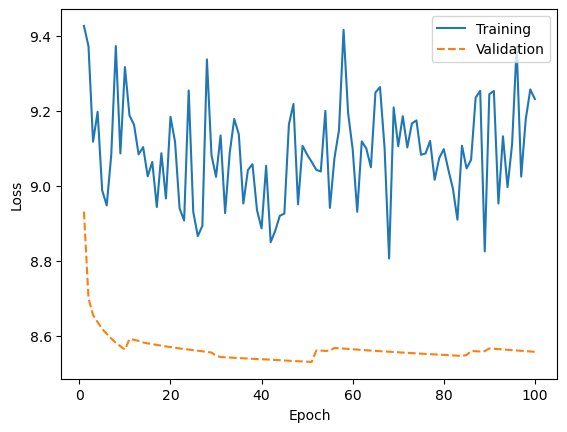

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

After training the base neural net, we construct the test-time predictor:

In [ ]:
survival_kernets_model.training_data = (X_train_np.astype('float32'),
                                        (Y_train_discrete_np, D_train_discrete_np))
survival_kernets_model.train_embeddings = survival_kernets_model.predict(X_train_np.astype('float32'),
                                                                         batch_size=batch_size)
survival_kernets_model.duration_index = time_grid_train_np
survival_kernets_model.build_ANN_index()

### Summary function fine-tuning

We begin by making a backup copy of the summary functions (these are the death counts and at risk counts over time for the different exemplars). In case summary fine-tuning does not yield an improvement in a validation set evaluation metric of our choosing, then we could restore the summary functions (to what they were prior to summary function fine-tuning).

In [ ]:
init_summary_functions = survival_kernets_model.get_summary_functions()

best_val_loss_no_summary_finetune = best_val_loss

Now we construct a new PyTorch model that views the kernel function as fixed and where we only optimize over the summary functions.

In [ ]:
from survival_kernets.models import NKSSummary, NKSSummaryLoss

summary_finetune_net = NKSSummary(survival_kernets_model, init_summary_functions)
summary_finetune_loss = NKSSummaryLoss(alpha, sigma)

Next, we proceed with minibatch gradient descent.

In [ ]:
summary_finetune_learning_rate = 0.005
summary_finetune_num_epochs = 20

optimizer = torch.optim.Adam(summary_finetune_net.parameters(),
                             lr=summary_finetune_learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(summary_finetune_num_epochs):
    summary_finetune_net.train()
    for X_batch, Y_batch, D_batch in train_loader:
        embedding_vectors = base_neural_net(X_batch)
        neural_net_output = summary_finetune_net(embedding_vectors)
        loss_batch = summary_finetune_loss(neural_net_output, Y_batch, D_batch)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    summary_finetune_net.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            embedding_vectors = base_neural_net(X_batch)
            batch_num_points = X_batch.size(0)
            neural_net_output = summary_finetune_net(embedding_vectors)
            train_loss += summary_finetune_loss(neural_net_output, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            embedding_vectors = base_neural_net(X_batch)
            batch_num_points = X_batch.size(0)
            neural_net_output = summary_finetune_net(embedding_vectors)
            val_loss += summary_finetune_loss(neural_net_output, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(summary_finetune_net.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
summary_finetune_net.load_state_dict(best_params)

Epoch 1 - train loss 3.0533876419067383 - val loss 4.166548252105713
Epoch 2 - train loss 3.0483875274658203 - val loss 4.164268970489502
Epoch 3 - train loss 3.044198751449585 - val loss 4.162930011749268
Epoch 4 - train loss 3.040602922439575 - val loss 4.162647724151611
Epoch 5 - train loss 3.0377650260925293 - val loss 4.162261962890625
Epoch 6 - train loss 3.035033941268921 - val loss 4.162229537963867
Epoch 7 - train loss 3.0319972038269043 - val loss 4.162333011627197
Epoch 8 - train loss 3.0293469429016113 - val loss 4.16249418258667
Epoch 9 - train loss 3.02689266204834 - val loss 4.162682056427002
Epoch 10 - train loss 3.024409770965576 - val loss 4.162750244140625
Epoch 11 - train loss 3.0218756198883057 - val loss 4.163153171539307
Epoch 12 - train loss 3.019639492034912 - val loss 4.163506984710693
Epoch 13 - train loss 3.0173070430755615 - val loss 4.1642231941223145
Epoch 14 - train loss 3.0155696868896484 - val loss 4.164967060089111
Epoch 15 - train loss 3.013159751892

<All keys matched successfully>

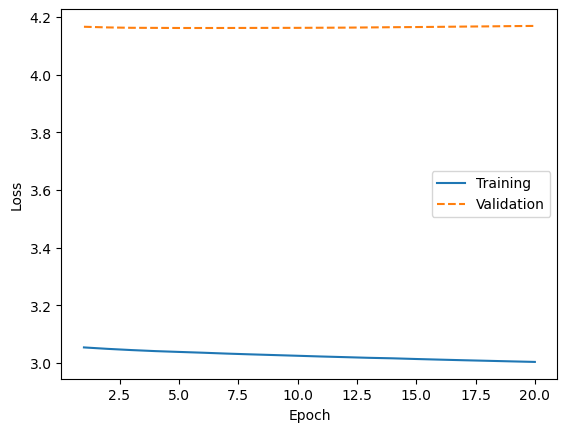

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, summary_finetune_num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, summary_finetune_num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

We use the validation set loss to decide on whether to use summary fine-tuning. To reiterate, it is possible to use other evaluation metrics on the validation set (e.g., validation set time-dependent concordance index, validation set integrated Brier score, etc) to decide on whether to use summary fine-tuning.

In [ ]:
if best_val_loss < best_val_loss_no_summary_finetune:
    summary_functions, baseline_event_counts, baseline_at_risk_counts = \
        summary_finetune_net.get_exemplar_summary_functions_baseline_event_at_risk_counts()
    survival_kernets_model.load_summary_functions(summary_functions,
                                                  baseline_event_counts,
                                                  baseline_at_risk_counts)
else:
    survival_kernets_model.load_summary_functions(init_summary_functions)

### Predicting survival curves on the test set

We begin by preprocessing the test data using the preprocessor built using training data.

In [ ]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor).astype('float32')

Interpolation works the same way as in the DeepHit demo:

In [ ]:
# here we interpolate by a factor of 10 (so that if we initially had m time steps, we would now have (m-1)*10 + 1 time steps)
interpolation_factor = 10
surv_test_interp_df = survival_kernets_model.interpolate(interpolation_factor).predict_surv_df(X_test_np, batch_size=batch_size)
time_grid_train_interp_np = surv_test_interp_df.index.to_numpy()  # the interpolated time grid is an interpolated version of the *training*  time grid
surv_test_interp_np = surv_test_interp_df.to_numpy().T

Here's a plot of the predicted survival function for the 0th test data point:

Text(0, 0.5, 'Survival probability')

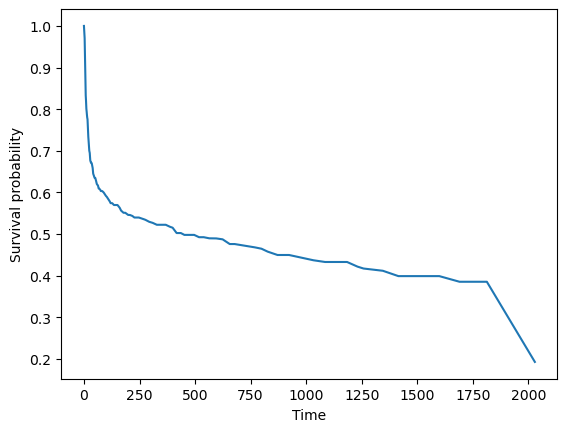

In [ ]:
plt.plot(time_grid_train_interp_np, surv_test_interp_np[0])
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Computing evaluation metrics on the test set

Here, we use the interpolated survival functions (along with their corresponding interpolated time grid).

As for choosing evaluation times, we still pick these based on the test set's observed times.

In [ ]:
test_time_grid_np = np.unique(Y_test_np)

#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [ ]:
from pycox.evaluation import EvalSurv

eval_pycox = EvalSurv(surv_test_interp_df, Y_test_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')
print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.6234939415941755


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

In [ ]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(test_time_grid_np)),
                     int(.5 * len(test_time_grid_np)),
                     int(.75 * len(test_time_grid_np))]

for eval_time_index in eval_time_indices:
    eval_time = test_time_grid_np[eval_time_index]

    # find the interpolated time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_interp_np))
    surv_values_at_eval_time_np = surv_test_interp_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 316.0 - truncated time-dependent concordance: 0.6058863136077733
Eval time 693.0 - truncated time-dependent concordance: 0.603264798900504
Eval time 1291.0 - truncated time-dependent concordance: 0.6051593108674329


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

In [ ]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = test_time_grid_np[eval_time_index]

    # find the interpolated time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_interp_np))
    surv_values_at_eval_time_np = surv_test_interp_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 316.0 - time-dependent AUC: 0.6711808368299854
Eval time 693.0 - time-dependent AUC: 0.7026890794238768
Eval time 1291.0 - time-dependent AUC: 0.7202774603143648


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_interp_np, time_grid_train_interp_np,
                         Y_test_np, D_test_np,
                         Y_train_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(test_time_grid_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 316.0 - Brier score: 0.22797539958785784
Eval time 693.0 - Brier score: 0.20568714212682168
Eval time 1291.0 - Brier score: 0.18208388172963547
Integrated Brier score: 0.1849633639931325


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is not D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 593.9348909221559


In [ ]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 712.0058803850914


# Section 5.2: SODEN Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to implement SODEN (Tang et al., 2022) using PyTorch, snippets of the original SODEN code by Tang et al. (2022), and `torchdiffeq`. For an overview of how SODEN works, please see Sections 5.1 and 5.2 in the monograph (the training and prediction procedures are specifically in Section 5.2). This demo largely builds off the exponential time-to-event prediction model demo (`S2.2.2_Exponential.ipynb`), so please look at that first as it describes the different steps of the experimental setup in more detail.

### Loading in the SUPPORT dataset (Knaus et al., 1995)

As with the earlier demo, we begin by defining the training, validation, and test sets.

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_np, D_full_train_np, \
        X_test_raw_np, Y_test_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('support')

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_np, Y_val_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 4968
Validation set size 1243
Test set size 2662

Features before preprocessing (14 total):
['age', 'female', 'race', 'num.co', 'diabetes', 'dementia', 'ca', 'meanbp', 'hrt', 'resp', 'temp', 'wblc', 'sod', 'crea']

Features after preprocessing (19 total):
['age_std', 'female', 'num.co_norm', 'diabetes', 'dementia', 'ca_norm', 'meanbp_std', 'hrt_std', 'resp_std', 'temp_std', 'wblc_std', 'sod_std', 'crea_std', 'race_blank', 'race_asian', 'race_black', 'race_hispanic', 'race_other', 'race_white']

Events: ['death']



We fit and apply a preprocessor to the training set. We apply (but do not re-fit) the preprocessor to the validation set.

In [ ]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Preparing training and validation sets for use with PyTorch

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train_np, dtype=torch.float32, device=device)
D_train = torch.tensor(D_train_np, dtype=torch.int32, device=device)
train_data = list(zip(X_train, Y_train, D_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
Y_val = torch.tensor(Y_val_np, dtype=torch.float32, device=device)
D_val = torch.tensor(D_val_np, dtype=torch.int32, device=device)
val_data = list(zip(X_val, Y_val, D_val))

### Setting up the SODEN model

In [ ]:
import torch
import torch.nn as nn
from SODEN.models import BaseSurvODEFunc

torch.manual_seed(0)

num_input_features = X_train.size(1)

# The base neural net takes in `num_input_features` + 2 inputs; in particular,
# the inputs are:
# - t (a nonnegative number)
# - H(t|x) (a nonnegative number)
# - x (consists of `num_input_features` numbers)
# The output is a single positive number for the hazard (to ensure that it's
# positive, we use softplus activation)
base_neural_net = nn.Sequential(nn.Linear(num_input_features + 2, 8),
                                nn.ReLU(),
                                nn.Linear(8, 1),
                                nn.Softplus()).to(device)

# the rest of the code in this cell is to basically glue/wrapper code so that we
# can use the base neural net with SODEN

# ------------------------------------------------------------------------------
# The following class is copied from the `ContextRecMLPODEFunc` class in:
#   https://github.com/jiaqima/SODEN/blob/main/models.py
# The only change is just that this version accepts a user-specified base neural
# net rather than the code creating its own base neural net.
class ODEFunc(BaseSurvODEFunc):
    def __init__(self, base_neural_net, num_features):
        super(ODEFunc, self).__init__()
        self.net = base_neural_net
        self.feature_size = num_features

    def forward(self, t, y):
        """
        Arguments:
          t: When self.batch_time_mode is False, t is a scalar indicating the
            time step to be evaluated. When self.batch_time_mode is True, t is
            a 1-D tensor with a single element [1.0].
          y: When self.batch_time_mode is False, y is a 1-D tensor with length
            2 + k, where the first dim indicates Lambda_t, the second dim
            indicates the final time step T to be evaluated, and the remaining
            k dims indicates the features. When self.batch_time_mode is True, y
            is a 2-D tensor with batch_size * (2 + k).
        """
        self.nfe += 1
        device = next(self.parameters()).device
        Lambda_t = y.index_select(-1, torch.tensor([0]).to(device)).view(-1, 1)
        T = y.index_select(-1, torch.tensor([1]).to(device)).view(-1, 1)
        x = y.index_select(-1, torch.tensor(range(2, y.size(-1))).to(device))
        # Rescaling trick
        # $\int_0^T f(s; x) ds = \int_0^1 T f(tT; x) dt$, where $t = s / T$
        inp = torch.cat(
            [Lambda_t,
             t.repeat(T.size()) * T,  # s = t * T
             x.view(-1, self.feature_size)], dim=1)
        output = self.net(inp) * T  # f(tT; x) * T
        zeros = torch.zeros_like(
            y.index_select(-1, torch.tensor(range(1, y.size(-1))).to(device))
        )
        output = torch.cat([output, zeros], dim=1)
        if self.batch_time_mode:
            return output
        else:
            return output.squeeze(0)
# ------------------------------------------------------------------------------

# wrapper to work with `odeint` from the `torchdiffeq` package
ode_func = ODEFunc(base_neural_net, num_input_features)

### Setting up the SODEN loss

In [ ]:
def ode_loss(X_batch, Y_batch, D_batch):
    # for every data point, we integrate starting from time 0
    all_zeros = torch.zeros(X_batch.size(0), dtype=torch.float, device=device)

    init_cond = torch.cat([all_zeros.view(-1, 1),
                           Y_batch.view(-1, 1),
                           X_batch],
                          dim=1)

    # we integrate from 0 (time 0) to 1 (the observed time per data point)
    t = torch.tensor([0., 1.]).to(device)

    # here's code to call the ODE solver
    ode_func.set_batch_time_mode(False)
    cumulative_hazards = \
        odeint(ode_func, init_cond, t, rtol=1e-4, atol=1e-8)[1:].squeeze()
    # note: the reason [1:].squeeze() shows up is as follows:
    # - the output of odeint is an iterable where the 0th element corresponds
    #   `t[0]` and the 1st element corresponds to `t[1]`
    # - by using the indexing `[1:]`, we are saying that we want the
    #   cumulative hazards at `t[1]`, which corresponds to the cumulative
    #   hazard evaluated at the observed time per data point
    # - after applying the indexing `[1;]`, the 0th dimension is no longer
    #   needed so we use `squeeze()` to get rid of it
    ode_func.set_batch_time_mode(True)

    # now we can evaluate the ODE function to get the hazards
    hazards = ode_func(t[1:], cumulative_hazards).squeeze()

    # some reformatting of the output
    cumulative_hazards = cumulative_hazards[:, 0]
    hazards = hazards[:, 0] / Y_batch.view(-1, 1)

    # use a clamp to avoid log 0
    log_hazards = torch.log(hazards.clamp(min=1e-8))

    # the loss is precisely L_{SODEN-NLL} in Section 5.2 of the monograph
    loss_batch = (-D_batch.view(-1, 1) * log_hazards
                  + cumulative_hazards).mean()
    return loss_batch

### Training the model using minibatch gradient descent

Just as in the exponential time-to-event prediction model demo, we use the validation set to decide on whether to use a previous epoch's learned model parameters.

In [ ]:
from copy import deepcopy
from torch.utils.data import DataLoader
from torchdiffeq import odeint_adjoint as odeint

# minibatch gradient descent
num_epochs = 10
batch_size = 128
learning_rate = 1e-2

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(base_neural_net.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    base_neural_net.train()
    for X_batch, Y_batch, D_batch in train_loader:
        loss_batch = ode_loss(X_batch, Y_batch, D_batch)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    base_neural_net.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            batch_num_points = X_batch.size(0)
            train_loss += ode_loss(X_batch, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            batch_num_points = X_batch.size(0)
            val_loss += ode_loss(X_batch, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(base_neural_net.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
base_neural_net.load_state_dict(best_params)

Epoch 1 - train loss 10.87423038482666 - val loss 10.589367866516113
Epoch 2 - train loss 10.071709632873535 - val loss 9.864890098571777
Epoch 3 - train loss 8.400647163391113 - val loss 8.180248260498047
Epoch 4 - train loss 4.833189487457275 - val loss 4.7748613357543945
Epoch 5 - train loss 4.5473785400390625 - val loss 4.480245113372803
Epoch 6 - train loss 4.529810428619385 - val loss 4.461924076080322
Epoch 7 - train loss 4.4411420822143555 - val loss 4.364966869354248
Epoch 8 - train loss 4.406889915466309 - val loss 4.325331211090088
Epoch 9 - train loss 4.404280185699463 - val loss 4.3172831535339355
Epoch 10 - train loss 4.43654203414917 - val loss 4.34867000579834
Best validation loss (4.3172831535339355) achieved at epoch 9


<All keys matched successfully>

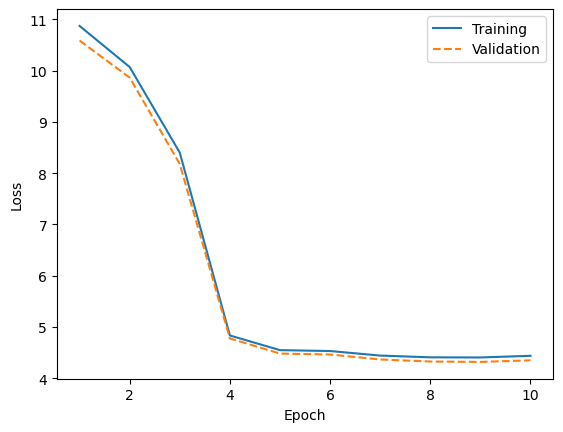

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Predicting test set survival curves

We begin by preprocessing the test data using the preprocessor built using training data.

In [ ]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor).astype('float32')
X_test_np.shape

(2662, 19)

Importantly, in our demos for other models, we would typically train a survival model, and the trained model would use a time grid based on training data. When we evaluate on test data and try to use the observed times from the test data, there would be some interpolation needed (since often the observed times in test data are not exactly the same as the ones in training data).

For SODEN, since the model is inherently continuous, we can just predict at whichever times we want, so we can directly just predict at, for instance, the unique observed times in the test data.

In [ ]:
import numpy as np
time_grid_np_test_np = np.unique(Y_test_np)

In [ ]:
def ode_predict(X_batch, time_grid_np):
    with torch.no_grad():
        inserted_0 = False
        if time_grid_np[0] != 0:
            time_grid_np = np.insert(time_grid_np, 0, 0)
            inserted_0 = True

        max_time = time_grid_np.max()
        time_grid_rescaled_np = time_grid_np / max_time
    
        # for every data point, we integrate starting from time 0 and we integrate
        # to the max time
        all_zeros = torch.zeros(X_batch.size(0), dtype=torch.float, device=device)
        all_max = max_time * \
            torch.ones(X_batch.size(0), dtype=torch.float, device=device)
    
        init_cond = torch.cat([all_zeros.view(-1, 1),
                               all_max.view(-1, 1),
                               X_batch],
                              dim=1)
    
        # we integrate from 0 (time 0) to 1 (the observed time per data point)
        t = torch.tensor(time_grid_rescaled_np, dtype=torch.float32).to(device)
    
        # here's code to call the ODE solver
        ode_func.set_batch_time_mode(False)
        cumulative_hazards = \
            odeint(ode_func, init_cond, t, rtol=1e-4, atol=1e-8)
        ode_func.set_batch_time_mode(True)

        if inserted_0:
            # ignore the 0th time which is 0
            return cumulative_hazards[1:, :, 0]
        else:
            return cumulative_hazards[:, :, 0]
        # output shape = (original time grid length, number of points)

In [ ]:
cumulative_hazards_test = ode_predict(torch.from_numpy(X_test_np).to(device), time_grid_np_test_np)
cumulative_hazards_test.size()

torch.Size([1061, 2662])

We can easily back out survival functions:

In [ ]:
surv_test_np = np.exp(-cumulative_hazards_test.cpu().numpy().T)

Here's a plot of the predicted survival function for the 0th test data point:

Text(0, 0.5, 'Survival probability')

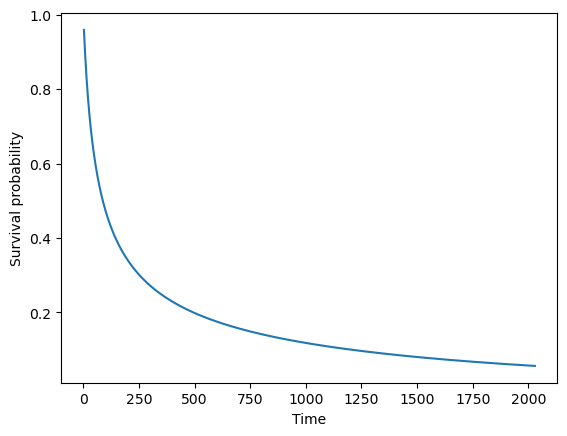

In [ ]:
plt.plot(time_grid_np_test_np, surv_test_np[0])
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Computing test set evaluation metrics

#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [ ]:
import pandas as pd
from pycox.evaluation import EvalSurv

# PyCox's EvalSurv expects the predicted test data's survival functions to be in
# a Pandas DataFrame where the rows index time, and the columns index data points
surv_test_df = pd.DataFrame(surv_test_np.T, index=time_grid_np_test_np)
eval_pycox = EvalSurv(surv_test_df, Y_test_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')

print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.5999961596954834


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

In [ ]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(time_grid_np_test_np)),
                     int(.5 * len(time_grid_np_test_np)),
                     int(.75 * len(time_grid_np_test_np))]

for eval_time_index in eval_time_indices:
    eval_time = time_grid_np_test_np[eval_time_index]
    surv_values_at_eval_time_np = surv_test_np[:, eval_time_index]
    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 316.0 - truncated time-dependent concordance: 0.6003177723541635
Eval time 693.0 - truncated time-dependent concordance: 0.6000619206152142
Eval time 1291.0 - truncated time-dependent concordance: 0.5965819731040101


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

In [ ]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = time_grid_np_test_np[eval_time_index]

    # find the interpolated time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_np_test_np))
    surv_values_at_eval_time_np = surv_test_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 316.0 - time-dependent AUC: 0.6427538523851566
Eval time 693.0 - time-dependent AUC: 0.6553645331114935
Eval time 1291.0 - time-dependent AUC: 0.6485517166931463


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_np, time_grid_np_test_np,
                         Y_test_np, D_test_np,
                         Y_train_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(time_grid_np_test_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 316.0 - Brier score: 0.2361933262739466


/home/george/anaconda3/lib/python3.12/site-packages/SurvivalEVAL/Evaluator.py:59: UserWarning: The first time coordinate is not 0. A authentic survival curve should start from 0 with 100% survival probability. \Adding 0 to the beginning of the time coordinates and 1 to the beginning of the predicted curves.
  warnings.warn("The first time coordinate is not 0. "


Eval time 693.0 - Brier score: 0.21787226061435294
Eval time 1291.0 - Brier score: 0.20312653778237788
Integrated Brier score: 0.20095424799187958


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is not D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

In [ ]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 616.4241960737193


In [ ]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 734.9082637692605


# Section 6.1.4: DeepHit (Competing Events) Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to implement DeepHit with competing risks (Lee et al., 2018) using PyCox and PyTorch. For an overview of how the DeepHit model works, please see Section 6.1.4 of the monograph. This demo builds off the DeepHit (single event) demo (`S2.3.3_DeepHit_single.ipynb`), so please look at that first. We now consider a setting where there are two competing events. We specifically use the PBC dataset (Fleming and Harrington, 1991), for which the first event is "death" and the second is "transplanted". Note that the PBC dataset is actually a time series dataset but per data point, we only consider the initial time step, so that we reduce it to a tabular dataset. Now that we consider two competing events, we use PyCox's `DeepHit` model (instead of `DeepHitSingle` as in the earlier demo).

### Loading in the PBC dataset (Fleming and Harrington, 1991)

We begin by defining the training, validation, and test sets.

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_np, D_full_train_np, \
        X_test_raw_np, Y_test_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('pbc', competing=True)

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_np, Y_val_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 1088
Validation set size 273
Test set size 584

Features before preprocessing (15 total):
['D-penicil', 'female', 'ascites', 'hepatomegaly', 'spiders', 'edema', 'histologic', 'serBilir', 'serChol', 'albumin', 'alkaline', 'SGOT', 'platelets', 'prothrombin', 'age']

Features after preprocessing (17 total):
['D-penicil', 'female', 'ascites', 'hepatomegaly', 'spiders', 'histologic_norm', 'serBilir_std', 'serChol_std', 'albumin_std', 'alkaline_std', 'SGOT_std', 'platelets_std', 'prothrombin_std', 'age_std', 'edema_no', 'edema_yes_despite_diuretics', 'edema_yes_without_diuretics']

Events: ['death', 'transplanted']



We fit and apply a preprocessor to the training set. We apply (but do not re-fit) the preprocessor to the validation set.

In [ ]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Discretizing time

We use PyCox's provided `LabTransDiscreteTime` class that helps with discretizing time.

In [ ]:
import numpy as np
from pycox.preprocessing.label_transforms import LabTransDiscreteTime

# ----------------------------------------------------------------------
# as pointed out in PyCox's DeepHit for competing risks demo, we need a
# custom label transformer to support multiple critical events
# https://github.com/havakv/pycox/blob/master/examples/deephit_competing_risks.ipynb
class LabTransform(LabTransDiscreteTime):
    def transform(self, durations, events):
        durations, is_event = super().transform(durations, events > 0)
        events[is_event == 0] = 0
        return durations, events.astype('int64')
# ----------------------------------------------------------------------

num_time_steps = 16  # set this to 0 to use all unique times in which any critical event happens

if num_time_steps == 0:
    mask = (D_train_np >= 1)  # boolean mask specifying which training points were not censored
    label_transform = LabTransform(np.unique(Y_train_np[mask]))
else:
    # use a quantile based discretization, which could possibly end up using fewer than the
    # number of time steps requested (if it turns out that in the dataset, there are many
    # duplicate observed times)
    label_transform = LabTransform(num_time_steps, scheme='quantiles')

Y_train_discrete_np, D_train_discrete_np = label_transform.fit_transform(Y_train_np, D_train_np)
Y_val_discrete_np, D_val_discrete_np = label_transform.transform(Y_val_np, D_val_np)
# note: PyCox's discretization code allows for the possibility that the event indicator changes
# (if a patient's survival time is known so that the event indicator is 1, but the survival time
# is after the maximum discrete time grid time, then the patient's event indicator is changed to
# being censored)

time_grid_train_np = label_transform.cuts
output_num_time_steps = len(time_grid_train_np)
print(f'Number of time steps to be used with DeepHit: {output_num_time_steps}')
print('Time grid:', time_grid_train_np)

Number of time steps to be used with DeepHit: 16
Time grid: [ 0.          0.2765305   0.86518455  1.5660936   2.1602235   2.883036
  3.5593035   4.205454    5.013142    5.790713    6.6203046   7.90713
  9.114554   10.510897   13.782719   14.152338  ]


### Preparing training and validation sets for use with PyTorch

Note that at this point the observed times have been converted into discrete indices. Note that at the time of writing, the code is a bit picky about the data types used.

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train_discrete_np, dtype=torch.int64, device=device)
D_train = torch.tensor(D_train_discrete_np, dtype=torch.int32, device=device)
train_data = list(zip(X_train, Y_train, D_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
Y_val = torch.tensor(Y_val_discrete_np, dtype=torch.int64, device=device)
D_val = torch.tensor(D_val_discrete_np, dtype=torch.int32, device=device)
val_data = list(zip(X_val, Y_val, D_val))

### Setting up the DeepHit model and loss

We are now ready to set up the DeepHit model using PyCox's `DeepHit` class. The main difference between this class and the `DeepHitSingle` class in the earlier DeepHit (single event) demo is that the base neural net's output needs to be of the shape (batch size, number of critical events, number of discrete time steps).

In [ ]:
import torch.nn as nn
from pycox.models import DeepHit

torch.manual_seed(0)

class BasicMLPForDeepHit(nn.Module):
    def __init__(self, num_input_features, num_critical_events, num_hidden):
        super(BasicMLPForDeepHit, self).__init__()

        self.num_critical_events = num_critical_events
        self.mlp = nn.Sequential(
            nn.Linear(num_input_features, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden,
                      num_critical_events * output_num_time_steps)).to(device)

    def forward(self, inputs):
        mlp_output = self.mlp(inputs)
        return mlp_output.view(inputs.size(0), self.num_critical_events, -1)

num_input_features = X_train.size(1)

base_neural_net = BasicMLPForDeepHit(num_input_features, 2, 8).to(device)

deephit_model = DeepHit(base_neural_net, alpha=0.9, sigma=0.1, device=device,
                        duration_index=time_grid_train_np)
deephit_loss = deephit_model.loss  # we'll see how to use this loss function in the next code cell

### Training the model using minibatch gradient descent

Just as in the exponential time-to-event prediction model demo, we use the validation set to decide on whether to use a previous epoch's learned model parameters.

In [ ]:
from copy import deepcopy
from torch.utils.data import DataLoader
from pycox.models.data import pair_rank_mat

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 0.005

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(base_neural_net.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    base_neural_net.train()
    for X_batch, Y_batch, D_batch in train_loader:
        neural_net_output = base_neural_net(X_batch)

        rank_mat = pair_rank_mat(Y_batch.cpu().numpy(), D_batch.cpu().numpy())
        rank_mat = torch.tensor(rank_mat, dtype=torch.int, device=device)

        loss_batch = deephit_loss(neural_net_output, Y_batch, D_batch, rank_mat)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    base_neural_net.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            rank_mat = pair_rank_mat(Y_batch.cpu().numpy(), D_batch.cpu().numpy())
            rank_mat = torch.tensor(rank_mat, dtype=torch.int, device=device)
            train_loss += deephit_loss(neural_net_output, Y_batch, D_batch, rank_mat) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            rank_mat = pair_rank_mat(Y_batch.cpu().numpy(), D_batch.cpu().numpy())
            rank_mat = torch.tensor(rank_mat, dtype=torch.int, device=device)
            val_loss += deephit_loss(neural_net_output, Y_batch, D_batch, rank_mat) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(base_neural_net.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
base_neural_net.load_state_dict(best_params)

Epoch 1 - train loss 1.8580601215362549 - val loss 1.9956085681915283
Epoch 2 - train loss 1.779083490371704 - val loss 1.9252431392669678
Epoch 3 - train loss 1.6905831098556519 - val loss 1.848314881324768
Epoch 4 - train loss 1.6160452365875244 - val loss 1.7816944122314453
Epoch 5 - train loss 1.5563222169876099 - val loss 1.728129506111145
Epoch 6 - train loss 1.508585810661316 - val loss 1.6877520084381104
Epoch 7 - train loss 1.473837971687317 - val loss 1.6661206483840942
Epoch 8 - train loss 1.4473427534103394 - val loss 1.6554330587387085
Epoch 9 - train loss 1.4248652458190918 - val loss 1.6356233358383179
Epoch 10 - train loss 1.406496286392212 - val loss 1.6300891637802124
Epoch 11 - train loss 1.393070936203003 - val loss 1.6284443140029907
Epoch 12 - train loss 1.3795939683914185 - val loss 1.623216986656189
Epoch 13 - train loss 1.3689498901367188 - val loss 1.6208003759384155
Epoch 14 - train loss 1.3580920696258545 - val loss 1.6169861555099487
Epoch 15 - train loss 1

<All keys matched successfully>

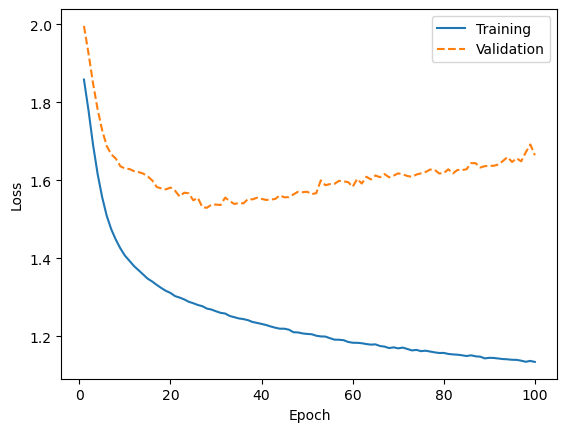

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Predicting test set cumulative incidence functions (CIFs)

We begin by preprocessing the test data using the preprocessor built using training data.

In [ ]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor).astype('float32')
X_test_np.shape

(584, 17)

PyCox has built-in functionality for predicting cumulative incidence functions (CIFs):

In [ ]:
cif_test_np = deephit_model.predict_cif(X_test_np, batch_size=batch_size, to_cpu=True, numpy=True)
cif_test_np.shape  # shape: (number of critical events, number of time steps in `time_grid_train_np`, number of test points)

(2, 16, 584)

Here, we plot test subject 0's CIFs for the two events:

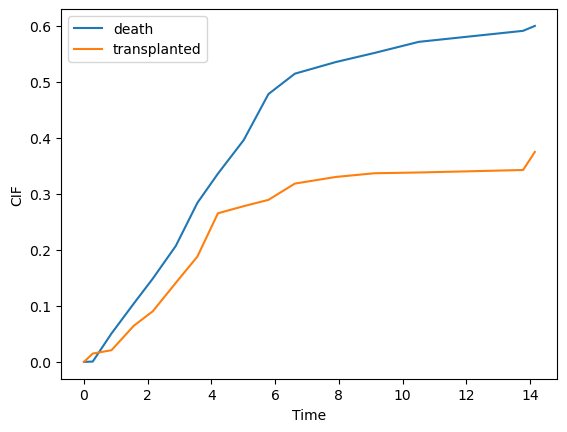

In [ ]:
for event_idx, event in enumerate(events):
    plt.plot(time_grid_train_np, cif_test_np[event_idx, :, 0], label=event)
plt.xlabel('Time')
plt.ylabel('CIF')
plt.legend()

### Computing test set evaluation metrics

At the time of writing, survival analysis evaluation metrics that have been implemented in Python typically do not handle the competing risks setup. However, by carefully setting up the inputs to these evaluation metrics, we can evaluate CIFs using the evaluation metrics described in Section 6.1.5 of the monograph.

Some metrics depend on evaluation times, which we pick based on the test set's observed times.

In [ ]:
time_grid_test_np = np.unique(Y_test_np)

#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [ ]:
import pandas as pd
from pycox.evaluation import EvalSurv

for event_idx_minus_one, event in enumerate(events):
    one_minus_cif_df = pd.DataFrame(1 - cif_test_np[event_idx_minus_one, :, :], index=time_grid_train_np)

    # remember that in `Y_test_np`, the critical events are numbered starting from 1 and not 0
    eval_pycox = EvalSurv(one_minus_cif_df, Y_test_np, 1*(D_test_np == (event_idx_minus_one + 1)))

    C_td = eval_pycox.concordance_td('antolini')
    print(f'Event "{event}" - time-dependent concordance index: {C_td}')

Event "death" - time-dependent concordance index: 0.8273025466191436
Event "transplanted" - time-dependent concordance index: 0.8393383674937073


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

Note that the training data are specifically used to estimate the censoring distribution (for inverse probability of censoring weights -- the $w_i$ weights in equation (6.8) of the monograph), so it suffices to set the training event indicators to be 1 if *any* of the competing critical events happen, and 0 if censoring happens.

In [ ]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(1*(D_train_np >= 1), Y_train_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(time_grid_test_np)),
                     int(.5 * len(time_grid_test_np)),
                     int(.75 * len(time_grid_test_np))]

for event_idx_minus_one, event in enumerate(events):
    # convert test labels into the structured array format used by scikit-survival
    labels_test_sksurv = Surv.from_arrays(1*(D_test_np == (event_idx_minus_one + 1)), Y_test_np)

    for eval_time_index in eval_time_indices:
        eval_time = time_grid_test_np[eval_time_index]

        # find the training time grid's time point closest to the evaluation time
        interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_np))
        cif_values_at_eval_time_np = cif_test_np[event_idx_minus_one, interp_time_index, :].T

        concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, cif_values_at_eval_time_np, tau=eval_time)[0]
        print(f'Event "{event}" - eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Event "death" - eval time 2.261526584625244 - truncated time-dependent concordance: 0.8872911850728724
Event "death" - eval time 4.591501712799072 - truncated time-dependent concordance: 0.8472873120646975
Event "death" - eval time 7.365020275115967 - truncated time-dependent concordance: 0.799431264382065
Event "transplanted" - eval time 2.261526584625244 - truncated time-dependent concordance: 0.8963368951719595
Event "transplanted" - eval time 4.591501712799072 - truncated time-dependent concordance: 0.8631724433225237
Event "transplanted" - eval time 7.365020275115967 - truncated time-dependent concordance: 0.8526024563183686


#### Brier score (Graf et al., 1999) generalized to competing risks

In [ ]:
def compute_brier_competing(cif_values_at_time_horizon, censoring_kmf,
                            Y_test, D_test, event_of_interest, time_horizon):
    n = len(Y_test)
    assert len(D_test) == n

    residuals = np.zeros(n)
    for idx in range(n):
        observed_time = Y_test[idx]
        event_indicator = D_test[idx]
        if observed_time > time_horizon:
            weight = censoring_kmf.predict(time_horizon)
            residuals[idx] = (cif_values_at_time_horizon[idx])**2 / weight
        else:
            weight = censoring_kmf.predict(observed_time)
            if event_indicator == event_of_interest:
                residuals[idx] = (1 - cif_values_at_time_horizon[idx])**2 / weight
            elif event_indicator != event_of_interest and event_indicator != 0:
                residuals[idx] = (cif_values_at_time_horizon[idx])**2 / weight
    return residuals.mean()

import lifelines
censoring_kmf = lifelines.KaplanMeierFitter()
censoring_kmf.fit(Y_train_np, 1 * (D_train_np == 0))

for event_idx_minus_one, event in enumerate(events):
    for eval_time_index in eval_time_indices:
        eval_time = time_grid_test_np[eval_time_index]

        # find the training time grid's time point closest to the evaluation time
        interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_np))
        cif_values_at_eval_time_np = cif_test_np[event_idx_minus_one, interp_time_index, :].T

        brier = \
            compute_brier_competing(cif_values_at_eval_time_np, censoring_kmf,
                                    Y_test_np, D_test_np, event_idx_minus_one + 1, eval_time)
        print(f'Event "{event}" - eval time {eval_time} - Brier score: {brier}')

Event "death" - eval time 2.261526584625244 - Brier score: 0.09193675186594207
Event "death" - eval time 4.591501712799072 - Brier score: 0.13306850304409157
Event "death" - eval time 7.365020275115967 - Brier score: 0.16196698633091045
Event "transplanted" - eval time 2.261526584625244 - Brier score: 0.021615843493337165
Event "transplanted" - eval time 4.591501712799072 - Brier score: 0.04634493540063809
Event "transplanted" - eval time 7.365020275115967 - Brier score: 0.061358183370050765


# Section 6.2.3: Dynamic-DeepHit Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo coves how to implement Dynamic-DeepHit with competing risks (Lee et al., 2019) using PyTorch (based on code by Vincent Jeanselme: https://github.com/Jeanselme/DynamicDeepHit). For an overview of how Dynamic-DeepHit works, please see Section 6.2.3 of the monograph. This demo builds off the DeepHit (competing events) demo (`S6.1.4_DeepHit_competing.ipynb`), so please look at that first. We again use the PBC dataset (Fleming and Harrington, 1991), for which the first event is "death" and the second is "transplanted". We now treat the PBC dataset as a variable-length time series dataset.

**Important**: In this demo, to avoid confusion in terminology, we use "time" to refer to different points in time of a time series, whereas we use "duration" to refer to the time-to-event outcome of interest, measured starting from the last time step per time series (refer to Sections 6.2.1 and 6.2.2 in the monograph for details). Note that for simplicity, we do *not* implement any of the strategies mentioned in "Practical considerations" at the end of Section 6.2.3 of the monograph.

*Disclaimer*: Note that Jeanselme's code uses various conventions specific to the `auton-survival` package. Our demo here intentionally tries to stick to what would be considered standard PyTorch conventions (so that as a warning up front, what we present here does not perfectly align with `auton-survival` demos but will more closely resemble how PyTorch is commonly used in many other settings, including for instance how model training works in TorchSurv). In particular, our demo here will expose some of the under the hood code logic as to make some preprocessing and model training steps more transparent (so that making modifications to any part of these should be more straightforward).

### Loading in the PBC dataset (Fleming and Harrington, 1991)

We begin by defining the training, validation, and test sets. Note that many variables are initially stored as Python lists to accommodate time series having varying lengths.

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_list, Y_full_train_list, D_full_train_list, \
        X_test_raw_list, Y_test_list, D_test_list, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('pbc', competing=True,
                                                                             time_series=True)

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_list, X_val_raw_list, Y_train_list, Y_val_list, D_train_list, D_val_list = \
    train_test_split(X_full_train_raw_list, Y_full_train_list, D_full_train_list,
                     test_size=.2, random_state=0)

print(f'Training set size {len(X_train_raw_list)}')
print(f'Validation set size {len(X_val_raw_list)}')
print(f'Test set size {len(X_test_raw_list)}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 174
Validation set size 44
Test set size 94

Features before preprocessing (15 total):
['D-penicil', 'female', 'ascites', 'hepatomegaly', 'spiders', 'edema', 'histologic', 'serBilir', 'serChol', 'albumin', 'alkaline', 'SGOT', 'platelets', 'prothrombin', 'age']

Features after preprocessing (17 total):
['D-penicil', 'female', 'ascites', 'hepatomegaly', 'spiders', 'histologic_norm', 'serBilir_std', 'serChol_std', 'albumin_std', 'alkaline_std', 'SGOT_std', 'platelets_std', 'prothrombin_std', 'age_std', 'edema_no', 'edema_yes_despite_diuretics', 'edema_yes_without_diuretics']

Events: ['death', 'transplanted']



We fit and apply a preprocessor to the training set. We apply (but do not re-fit) the preprocessor to the validation set.

In [ ]:
X_train_list, preprocessor = build_preprocessor_and_preprocess(X_train_raw_list)
X_val_list = apply_preprocessor(X_val_raw_list, preprocessor)

### Discretizing *durations* (i.e., discretizing time-to-event outcomes)

Recall that in earlier demos in which we discretized the time-to-event outcome, we had used PyCox's discretization code. Although we could reuse PyCox's discretization code here as well, instead we shall use discretization code from Jeanselme's `DynamicDeepHit` GitHub repository.

In [ ]:
import numpy as np

# ----------------------------------------------------------------------
# This snippet of code is taken from the `discretize` function (inside
# the DynamicDeepHit class) from here (where we have removed `self`
# since we now define this function outside of a Python class):
# https://github.com/Jeanselme/DynamicDeepHit/blob/main/ddh/ddh_api.py
def discretize(t, split, split_time=None):
    """
        Discretize the survival horizon

        Args:
            t (List of Array): Time of events
            split (int): Number of bins
            split_time (List, optional): List of bins (must be same length than split). Defaults to None.

        Returns:
            List of Array: Disretized events time
    """
    if split_time is None:
        _, split_time = np.histogram(np.concatenate(t), split - 1)
    t_discretized = np.array([np.digitize(t_, split_time, right = True) - 1 for t_ in t], dtype = object)
    return t_discretized, split_time
# ----------------------------------------------------------------------

num_durations = 16  # set this to 0 to use all unique durations in which any critical event happens

# discretize training durations
if num_durations == 0:
    # manually specify the duration grid
    Y_train_stacked_np = np.concatenate(Y_train_list)
    D_train_stacked_np = np.concatenate(D_train_list)
    mask = (D_train_stacked_np >= 1)  # boolean mask specifying which training points were not censored
    duration_grid_train_np = np.unique(Y_train_stacked_np[:, 0][mask])

    # the `discretize` function allows us to supply it with a pre-specified grid
    Y_train_discrete_np, _ = \
        discretize(Y_train_list,
                   len(duration_grid_train_np) - 1,
                   duration_grid_train_np)
else:
    Y_train_discrete_np, duration_grid_train_np \
        = discretize(Y_train_list, num_durations)

# discretize validation observed durations using the grid obtained based on training data
Y_val_discrete_np, _ = discretize(Y_val_list,
                                  len(duration_grid_train_np) - 1,
                                  duration_grid_train_np)

output_num_durations = len(duration_grid_train_np)
print(f'Number of discretized durations to be used with Dynamic-DeepHit: {output_num_durations}')
print('Duration grid:', duration_grid_train_np)

Number of discretized durations to be used with Dynamic-DeepHit: 16
Duration grid: [2.73792585e-03 9.56266224e-01 1.90979445e+00 2.86332273e+00
 3.81685114e+00 4.77037954e+00 5.72390747e+00 6.67743587e+00
 7.63096428e+00 8.58449268e+00 9.53802109e+00 1.04915495e+01
 1.14450769e+01 1.23986053e+01 1.33521338e+01 1.43056622e+01]


### Preparing training and validation sets for use with PyTorch

Since the different time series can vary in length, we use a standard approach for converting these to PyTorch tensors, which is to pad them so that they are the same length. Specifically, we first figure out what the maximum length is across training time series. Then for any training time series that is shorter than the maximum length, we add time steps at the end of them (so that there's a new feature vector full of NaNs for each of these new time steps) as to make sure that all training time series have the exact same length.

In [ ]:
# ----------------------------------------------------------------------
# This snippet of code is taken from:
# https://github.com/autonlab/DeepSurvivalMachines/blob/c454774199c389e7bb9fa3077f153cdf4f1e7696/dsm/utilities.py
def _get_padded_features(x):
    """Helper function to pad variable length RNN inputs with nans."""
    d = max([len(x_) for x_ in x])
    padx = []
    for i in range(len(x)):
        pads = np.nan*np.ones((d - len(x[i]),) + x[i].shape[1:])
        padx.append(np.concatenate([x[i], pads]))
    return np.array(padx)
# ----------------------------------------------------------------------

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_padded = torch.from_numpy(_get_padded_features(X_train_list)).type(torch.float32).to(device)
X_train_padded.size()  # shape = (number of data points, max number of time steps, number of features per time step)

torch.Size([174, 16, 17])

Per data point, we only use the last time step's target label information (i.e., the last time step's duration (discretized already) and event indicator):

In [ ]:
last_Y_train = torch.tensor([_[-1] for _ in Y_train_discrete_np]).type(torch.float32).to(device)
D_train = torch.tensor([_[-1] for _ in D_train_list]).type(torch.float32).to(device)
# each of these will be a 1D table with number of entries given by the number of data points

Now we put together the dataset that we will construct a PyTorch DataLoader object with:

In [ ]:
train_data = list(zip(X_train_padded, last_Y_train, D_train))

Here's the code for prepping the validation data the same way:

In [ ]:
X_val_padded = torch.from_numpy(_get_padded_features(X_val_list)).type(torch.float32).to(device)
last_Y_val = torch.tensor([_[-1] for _ in Y_val_discrete_np]).type(torch.float32).to(device)
D_val = torch.tensor([_[-1] for _ in D_val_list]).type(torch.float32).to(device)
val_data = list(zip(X_val_padded, last_Y_val, D_val))

### Setting up the Dynamic-DeepHit model and loss

We now set up a Dynamic-DeepHit model using Jeanselme's `DynamicDeepHitTorch` class.

In [ ]:
import torch.nn as nn
from pycox.models import DeepHit

torch.manual_seed(0)

from ddh.ddh_torch import DynamicDeepHitTorch
from ddh.losses import total_loss

dropout = .3
rnn_type = 'LSTM'  # Jeanselme's code supports the options of 'RNN', 'LSTM', and 'GRU'
num_rnn_layers = 2
num_hidden = 8  # RNN hidden layer number of nodes (i.e., dimension of RNN hidden layer)

# number of nodes for different hidden layers in f_{next_time_step}
# (this is the neural net for predicting the next time step's feature vector
# as stated in Section 6.2.3 in the monograph; in Jeanselme's code, this
# neural net is called the "longitudinal network"
layers_for_predicting_next_time_step = [32, 32]

# number of nodes for different hidden layers in f_{attention}
# (this is the neural net for determining attention weights that are used
# in computing a summary vector from the RNN as described in Section 6.2.3
# in the monograph; in Jeanselme's code, this neural net is also called the
# attention network)
layers_for_attention = [8, 8]

# number of nodes for different hidden layers in each critical event's
# original DeepHit MLP (see the bottom right of Figure 6.1 in the
# monograph); in Jeanselme's code, these MLPs are called the cause-specific
# networks (where each critical event is thought of as a "cause")
layers_for_each_deephit_event = [8]

num_input_features = X_train_padded.size(2)
dynamic_deephit_model = \
    DynamicDeepHitTorch(num_input_features,
                        output_num_durations,
                        num_rnn_layers,
                        num_hidden,
                        long_param={'layers': layers_for_predicting_next_time_step,
                                    'dropout': dropout},
                        att_param={'layers': layers_for_attention,
                                   'dropout': dropout},
                        cs_param={'layers': layers_for_each_deephit_event,
                                  'dropout': dropout},
                        typ=rnn_type,
                        risks=len(events)).to(device)
dynamic_deephit_loss = total_loss

### Training the model using minibatch gradient descent

Just as in the exponential time-to-event prediction model demo, we use the validation set to decide on whether to use a previous epoch's learned model parameters.

Jeanselme's Dynamic-DeepHit `total_loss` function views the loss function as:

$ \alpha\times\text{ranking loss} + \beta \times \text{negative log likelihood} + (1 - \alpha - \beta) \times \text{loss of prediction of next time steps' feature vectors}$,

where as a reminder, the ranking loss for DeepHit (and also Dynamic-DeepHit) has a hyperparameter $\sigma$ (see the loss function $L_{\text{DeepHit-ranking}}$ in Section 6.1.4 of the monograph; note that in the monograph, there is an additional hyperparameter $\eta$ that we are just treating as all ones).

The hyperparameters $\alpha$, $\beta$, and $\sigma$ are set below.

In [ ]:
from copy import deepcopy
from torch.utils.data import DataLoader

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 1e-2

# Dynamic-DeepHit loss function hyperparameters
alpha = .8
beta = .1
sigma = .1

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(dynamic_deephit_model.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    dynamic_deephit_model.train()
    for X_batch, Y_batch, D_batch in train_loader:
        X_batch = X_batch.to(device)
        # the `total_loss` function has been written so that it evalutes the model
        # for you, so there is no need to evaluate it ourselves prior to sending
        # the neural net's output to the loss function
        loss_batch = \
            total_loss(dynamic_deephit_model,
                       X_batch,
                       Y_batch,
                       D_batch,
                       alpha,
                       beta,
                       sigma)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    dynamic_deephit_model.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            X_batch = X_batch.to(device)
            batch_num_points = X_batch.size(0)
            train_loss += total_loss(dynamic_deephit_model,
                                     X_batch,
                                     Y_batch,
                                     D_batch,
                                     alpha,
                                     beta,
                                     sigma) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            X_batch = X_batch.to(device)
            batch_num_points = X_batch.size(0)
            val_loss += total_loss(dynamic_deephit_model,
                                   X_batch,
                                   Y_batch,
                                   D_batch,
                                   alpha,
                                   beta,
                                   sigma) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(dynamic_deephit_model.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
dynamic_deephit_model.load_state_dict(best_params)

Epoch 1 - train loss 247.502685546875 - val loss 82.81333923339844
Epoch 2 - train loss 250.00718688964844 - val loss 81.73088073730469
Epoch 3 - train loss 231.67796325683594 - val loss 80.12406158447266
Epoch 4 - train loss 225.209716796875 - val loss 77.67256164550781
Epoch 5 - train loss 212.74322509765625 - val loss 74.32438659667969
Epoch 6 - train loss 204.90618896484375 - val loss 70.28517150878906
Epoch 7 - train loss 193.29736328125 - val loss 65.89212799072266
Epoch 8 - train loss 184.64059448242188 - val loss 61.572078704833984
Epoch 9 - train loss 182.98582458496094 - val loss 57.86710739135742
Epoch 10 - train loss 178.58316040039062 - val loss 55.17209243774414
Epoch 11 - train loss 186.2574920654297 - val loss 53.3787841796875
Epoch 12 - train loss 173.02078247070312 - val loss 52.15653610229492
Epoch 13 - train loss 178.71426391601562 - val loss 51.44504165649414
Epoch 14 - train loss 169.9193878173828 - val loss 51.14988708496094
Epoch 15 - train loss 174.980819702148

<All keys matched successfully>

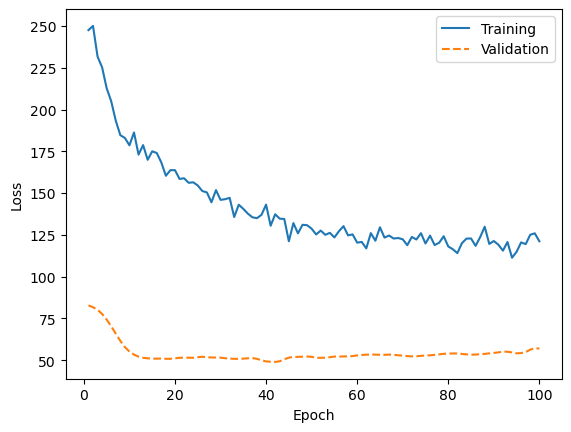

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Predicting cumulative incidence functions (CIFs) on the test set

We begin by preprocessing the test data using the preprocessor built using training data.

In [ ]:
X_test_list = apply_preprocessor(X_test_raw_list, preprocessor)
X_test_padded = torch.from_numpy(_get_padded_features(X_test_list)).type(torch.float32).to(device)
X_test_padded.size()

torch.Size([94, 16, 17])

We now get the neural net's output:

In [ ]:
with torch.no_grad():
    # we ignore the 0th output, which contains predictions of next time steps' feature vectors
    _, pmf_test = dynamic_deephit_model(X_test_padded)
    # note that what comes out of the model is *not* the CIFs but instead the PMFs
    # (we can back out the CIFs from the PMFs)
# `pmf_test` will be a list with length given by the number of critical events (2 in this case)

Each event's predicted PMFs is stored as a 2D table with shape (number of test points, number of discrete durations)

In [ ]:
pmf_test[0].size()

torch.Size([94, 16])

In [ ]:
cifs = []
for event_idx_minus_one in range(len(pmf_test)):
    cifs.append(pmf_test[event_idx_minus_one].cumsum(1))

Importantly, the code is written so that it only makes a prediction at the very last time step per test time series. If you wanted to have a prediction as you saw more and more of a time series, you would have to write additional code (this would be straightforward in that you just give the model a truncated version of a test time series such as only the first time step of it, and then only the first two time steps of it, etc).

Note that given this setup where we only predict at the last time step per test time series, if we believe that having time 0 correspond to the last time step makes sense for this setup, then we could compute evaluation metrics the same way as we did for the DeepHit competing risks demo. We illustrate this below. Note that for simplicity, we rearrange `cifs` into the same format as what gets outputted by PyCox's DeepHit model; namely, we create a Python variable `cif_test_np` that is a Numpy array with shape (number of critical events, number of time steps in `duration_grid_train_np`, number of test points).

In [ ]:
cif_test_np = np.array([cifs[event_idx_minus_one].cpu().numpy().T for event_idx_minus_one in range(len(events))])
cif_test_np.shape

(2, 16, 94)

Now we could reuse code from our earlier DeepHit (with competing risks) demo (although we now use the variable `duration_grid_train_np` instead of `time_grid_train_np`). For example, we plot test subject 0's CIFs for the two events:

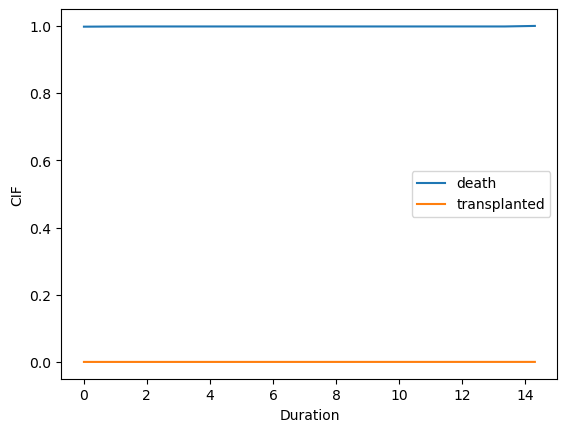

In [ ]:
for event_idx_minus_one, event in enumerate(events):
    plt.plot(duration_grid_train_np, cif_test_np[event_idx_minus_one, :, 0], label=event)
plt.xlabel('Duration')
plt.ylabel('CIF')
plt.legend()

### Computing evaluation metrics on the test set

We take the ground truth information from the last time step per training and test point.

In [ ]:
Y_train_np = np.array([_[-1] for _ in Y_train_list])
D_train_np = np.array([_[-1] for _ in D_train_list])
Y_test_np = np.array([_[-1] for _ in Y_test_list])
D_test_np = np.array([_[-1] for _ in D_test_list])
duration_grid_test_np = np.unique(Y_test_np)

#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [ ]:
import pandas as pd
from pycox.evaluation import EvalSurv

for event_idx_minus_one, event in enumerate(events):
    one_minus_cif_df = pd.DataFrame(1 - cif_test_np[event_idx_minus_one, :, :],
                                    index=duration_grid_train_np)

    # remember that in `Y_test_np`, the critical events are numbered starting from 1 and not 0
    eval_pycox = EvalSurv(one_minus_cif_df, Y_test_np, 1*(D_test_np == (event_idx_minus_one + 1)))

    C_td = eval_pycox.concordance_td('antolini')
    print(f'Event "{event}" - time-dependent concordance index: {C_td}')

Event "death" - time-dependent concordance index: 0.8275480059084195
Event "transplanted" - time-dependent concordance index: 0.5833333333333334


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

Note that the training data are specifically used to estimate the censoring distribution (for inverse probability of censoring weights -- the $w_i$ weights in equation (6.8) of the monograph), so it suffices to set the training event indicators to be 1 if *any* of the competing critical events happen, and 0 if censoring happens.

In [ ]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(1*(D_train_np >= 1), Y_train_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_duration_indices = [int(.25 * len(duration_grid_test_np)),
                         int(.5 * len(duration_grid_test_np)),
                         int(.75 * len(duration_grid_test_np))]

for event_idx_minus_one, event in enumerate(events):
    # convert test labels into the structured array format used by scikit-survival
    labels_test_sksurv = Surv.from_arrays(1*(D_test_np == (event_idx_minus_one + 1)), Y_test_np)

    for eval_duration_index in eval_duration_indices:
        eval_duration = duration_grid_test_np[eval_duration_index]

        # find the training time grid's time point closest to the evaluation time
        interp_time_index = np.argmin(np.abs(eval_duration - duration_grid_train_np))
        cif_values_at_eval_duration_np = cif_test_np[event_idx_minus_one, interp_time_index, :].T

        concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, cif_values_at_eval_duration_np, tau=eval_duration)[0]
        print(f'Event "{event}" - eval time {eval_duration} - truncated time-dependent concordance: {concordance}')

Event "death" - eval time 0.27926841378211975 - truncated time-dependent concordance: 0.8213490371924643
Event "death" - eval time 0.8159018754959106 - truncated time-dependent concordance: 0.8173471650865896
Event "death" - eval time 2.17391300201416 - truncated time-dependent concordance: 0.8221068712460827
Event "transplanted" - eval time 0.27926841378211975 - truncated time-dependent concordance: 0.7607712261789206
Event "transplanted" - eval time 0.8159018754959106 - truncated time-dependent concordance: 0.5796577279937458
Event "transplanted" - eval time 2.17391300201416 - truncated time-dependent concordance: 0.5471388396655726


#### Brier score (Graf et al., 1999) generalized to competing risks

In [ ]:
def compute_brier_competing(cif_values_at_time_horizon, censoring_kmf,
                            Y_test, D_test, event_of_interest, time_horizon):
    n = len(Y_test)
    assert len(D_test) == n

    residuals = np.zeros(n)
    for idx in range(n):
        observed_time = Y_test[idx]
        event_indicator = D_test[idx]
        if observed_time > time_horizon:
            weight = censoring_kmf.predict(time_horizon)
            residuals[idx] = (cif_values_at_time_horizon[idx])**2 / weight
        else:
            weight = censoring_kmf.predict(observed_time)
            if event_indicator == event_of_interest:
                residuals[idx] = (1 - cif_values_at_time_horizon[idx])**2 / weight
            elif event_indicator != event_of_interest and event_indicator != 0:
                residuals[idx] = (cif_values_at_time_horizon[idx])**2 / weight
    return residuals.mean()

import lifelines
censoring_kmf = lifelines.KaplanMeierFitter()
censoring_kmf.fit(Y_train_np, 1 * (D_train_np == 0))

for event_idx_minus_one, event in enumerate(events):
    for eval_duration_index in eval_duration_indices:
        eval_duration = duration_grid_test_np[eval_duration_index]

        # find the training time grid's time point closest to the evaluation time
        interp_time_index = np.argmin(np.abs(eval_duration - duration_grid_train_np))
        cif_values_at_eval_duration_np = cif_test_np[event_idx_minus_one, interp_time_index, :].T

        brier = \
            compute_brier_competing(cif_values_at_eval_duration_np, censoring_kmf,
                                    Y_test_np, D_test_np, event_idx_minus_one + 1, eval_duration)
        print(f'Event "{event}" - eval time {eval_duration} - Brier score: {brier}')

Event "death" - eval time 0.27926841378211975 - Brier score: 0.3206562259142652
Event "death" - eval time 0.8159018754959106 - Brier score: 0.22173445175171386
Event "death" - eval time 2.17391300201416 - Brier score: 0.1322642842322594
Event "transplanted" - eval time 0.27926841378211975 - Brier score: 0.0908043482623298
Event "transplanted" - eval time 0.8159018754959106 - Brier score: 0.11615339725288878
Event "transplanted" - eval time 2.17391300201416 - Brier score: 0.10071478281278182
